In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,inputs,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-10-27 13:57:18.003517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define Network Parameters

In [3]:
def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

In [4]:
N = 80
Nret = N
Nlgn = N

xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
dxs = np.abs(xs.flatten()[:,None] - xs.flatten()[None,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys.flatten()[:,None] - ys.flatten()[None,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds = np.sqrt(dxs**2 + dys**2)

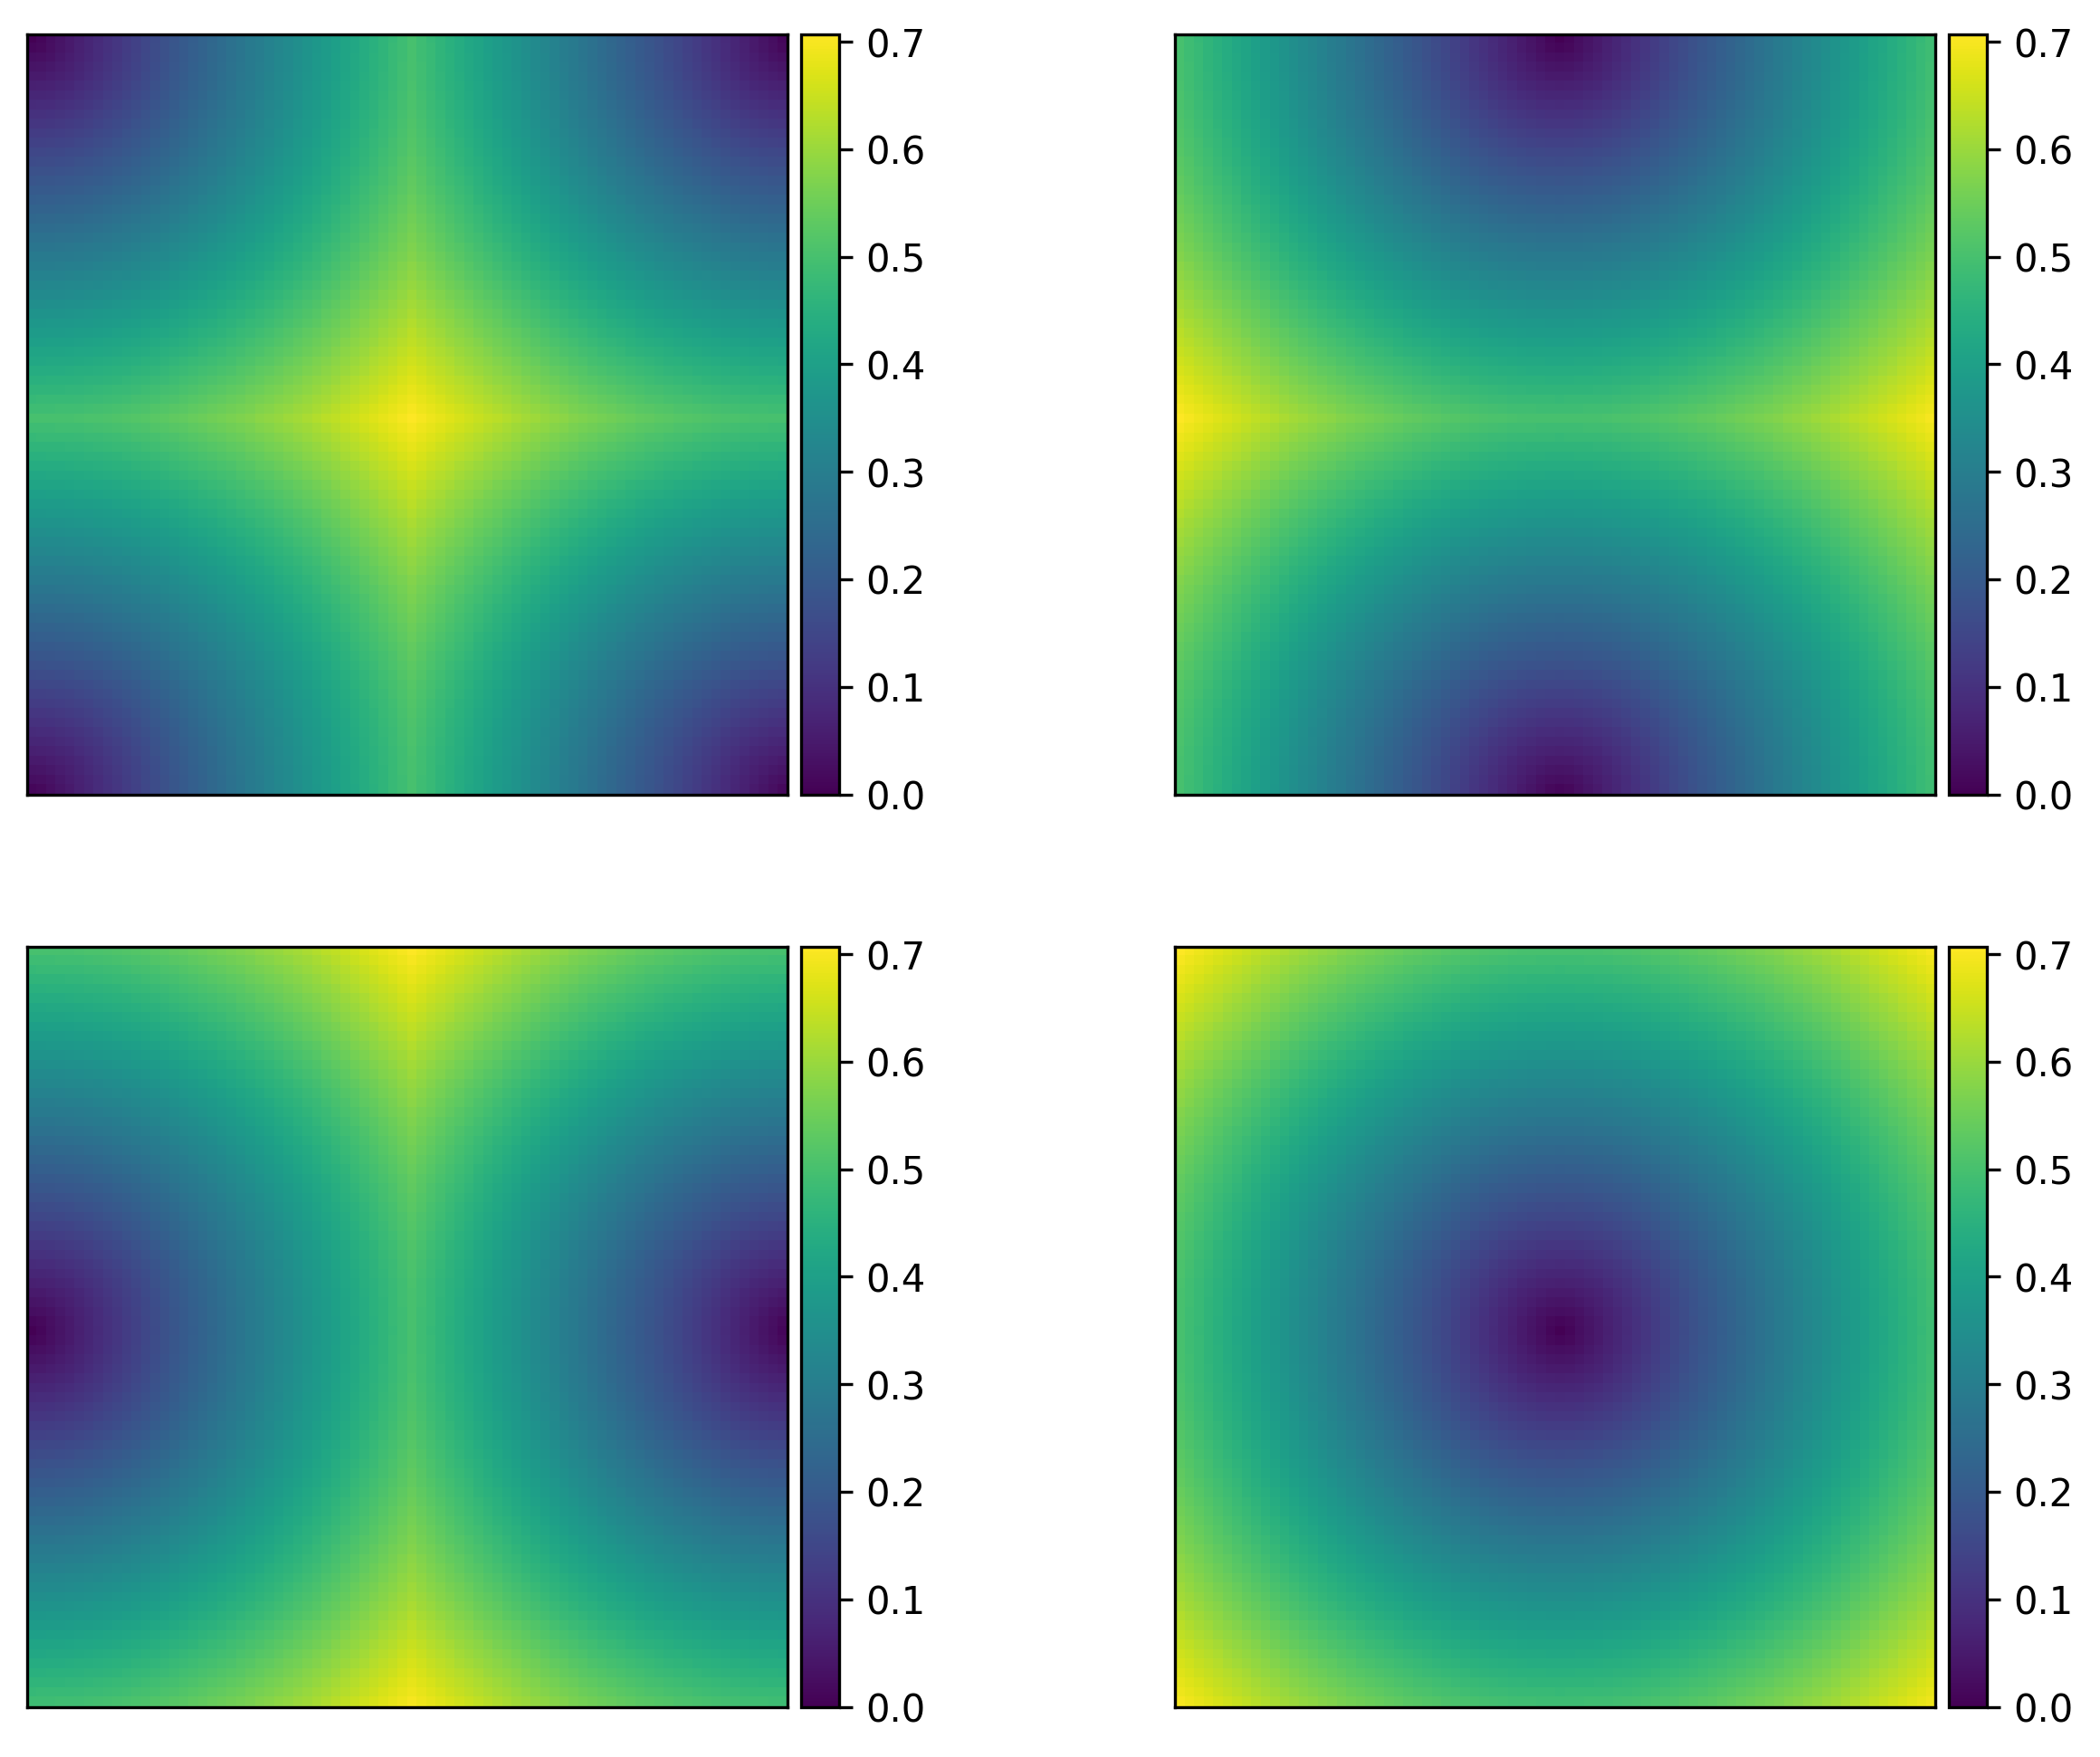

In [5]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0,0],ds.reshape(N,N,N,N)[0,0,:,:],cmap='viridis')
pf.imshowbar(fig,axs[0,1],ds.reshape(N,N,N,N)[0,N//2,:,:],cmap='viridis')
pf.imshowbar(fig,axs[1,0],ds.reshape(N,N,N,N)[N//2,0,:,:],cmap='viridis')
pf.imshowbar(fig,axs[1,1],ds.reshape(N,N,N,N)[N//2,N//2,:,:],cmap='viridis')

# Look at Stevens et al LGN Input with IID Retinal Activity

## Build Ret$\to$LGN Connectivity

In [6]:
conn_params = {
    'sigma1':  0.037,
    'sigma2':  0.15,
    'ampl1':   1.0,
    'ampl2':   1.0,
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'stevensetal': True
}

In [7]:
reload(connectivity)

conn = connectivity.Connectivity((N,N),(N,N),0)
WRtoT,_ = conn.create_matrix(conn_params,conn_params['profile'])

In [8]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

WRtoT_d = np.zeros(72)

for idx in range(72):
    WRtoT_d[idx] = np.mean(WRtoT[bin_idxs == idx])

Text(0.5, 1.0, 'Sum of Presynaptic Weights')

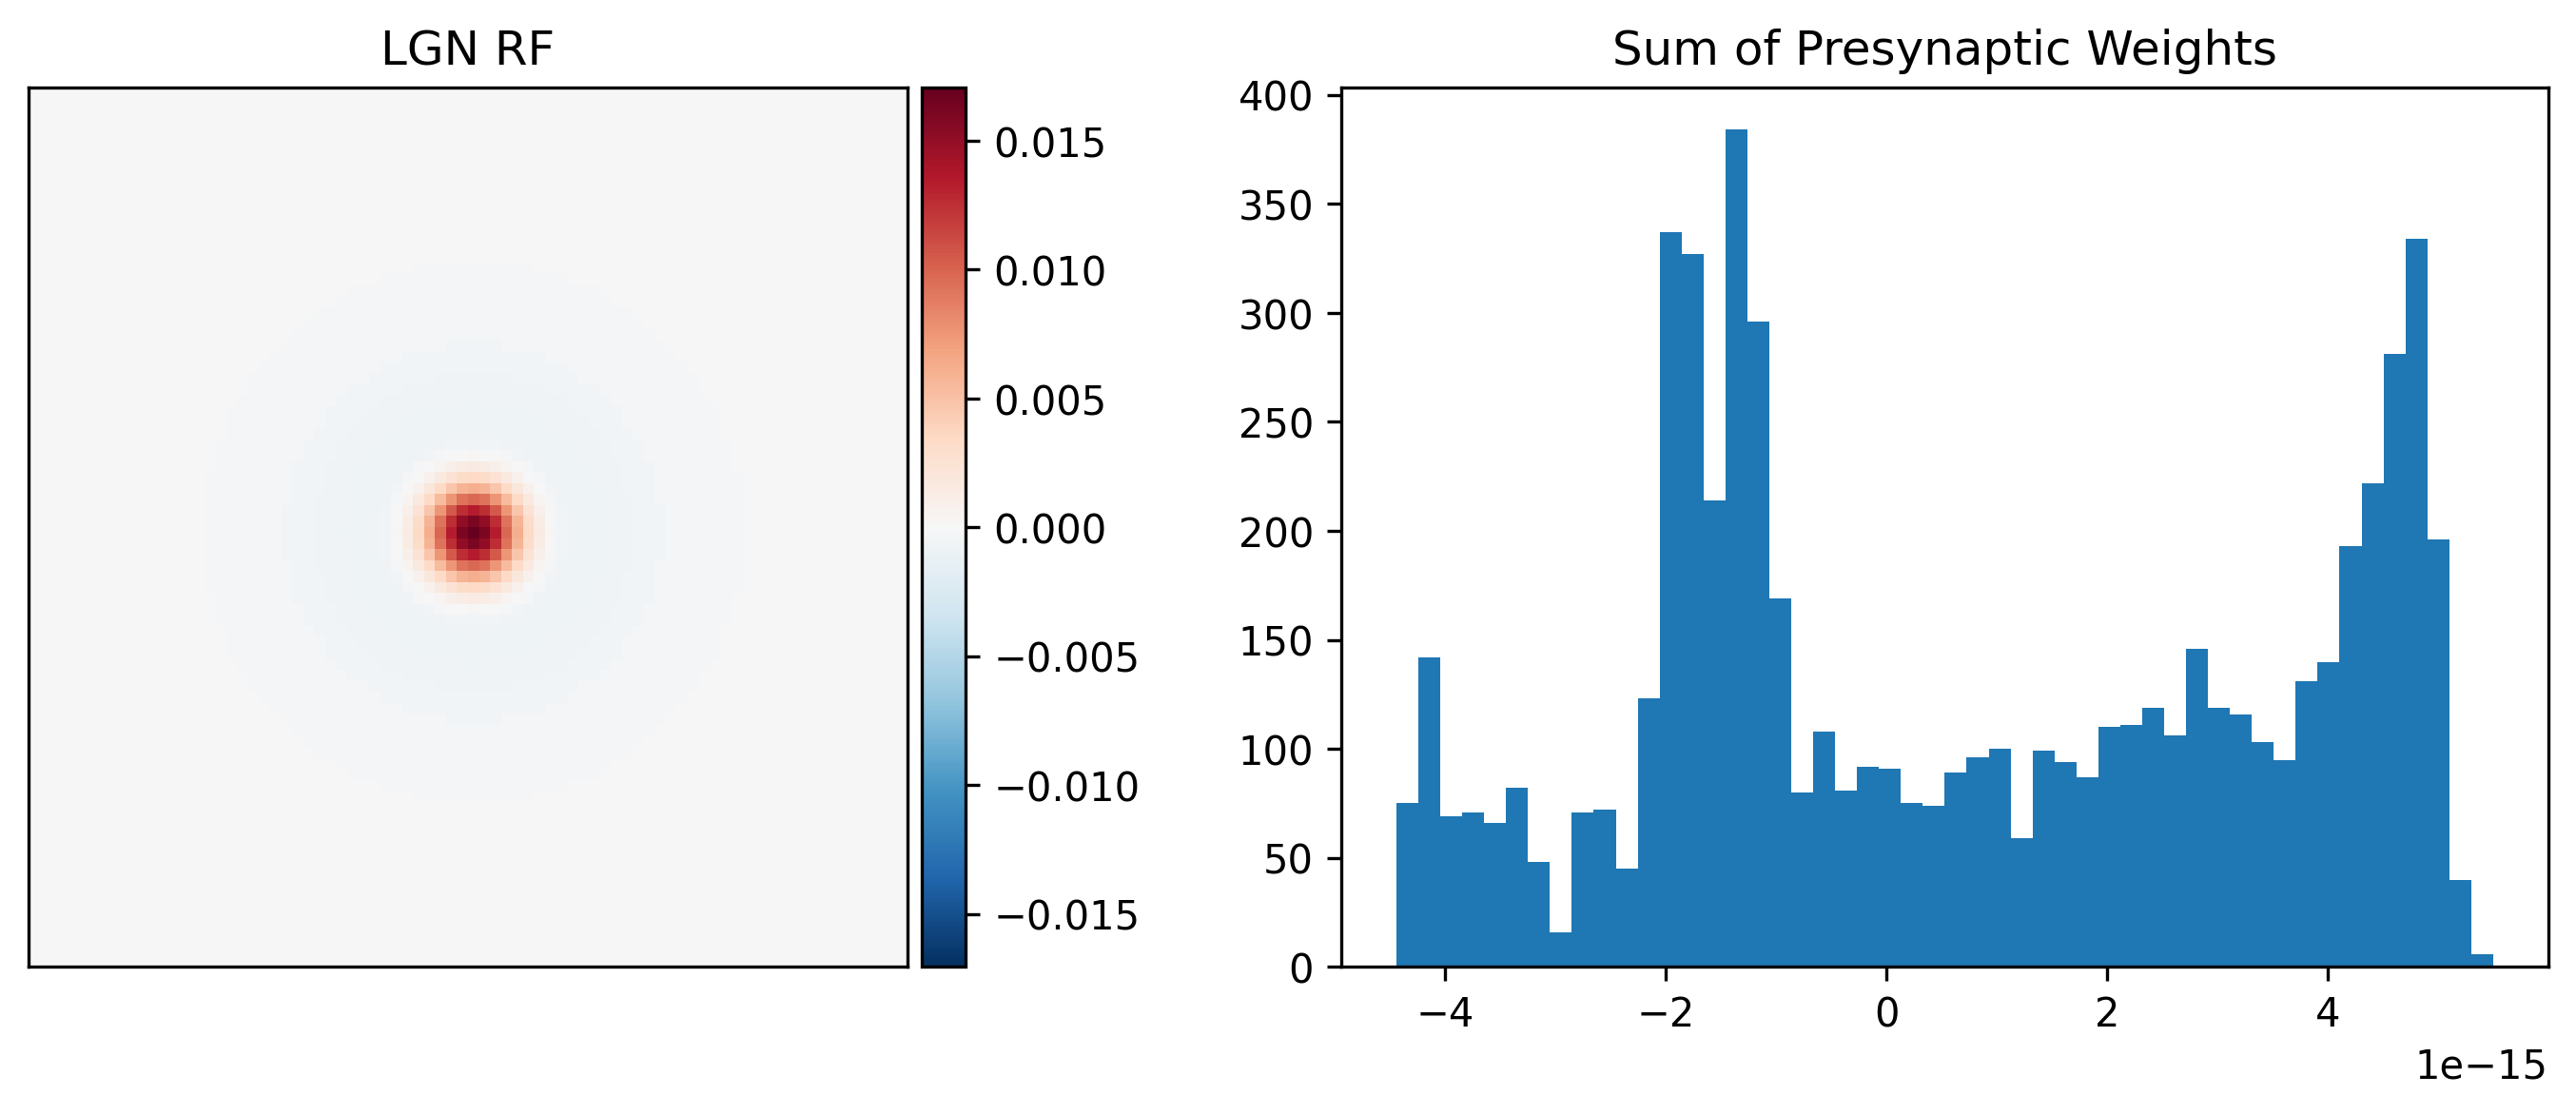

In [9]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WRtoT.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WRtoT)),vmax=np.max(np.abs(WRtoT)))

axs[1].hist(np.sum(WRtoT,1),50)

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')

## Create Retinal Activity Patterns

In [10]:
def stevens_gauss(x,y,ori,size=0.088388,aspect_ratio=4.66667,grid_size=1.0,n_grid=Nret):
    pts = np.arange(n_grid)*grid_size/n_grid - grid_size/2
    ysigma = size/2.0
    xsigma = aspect_ratio*ysigma
    
    dx,dy = np.meshgrid(pts,pts)
    
    tmp = np.cos(ori)*dx - np.sin(ori)*dy
    dy = np.sin(ori)*dx + np.cos(ori)*dy
    dx = tmp
    
    dx = dx/xsigma
    dy = dy/ysigma
    
    return np.roll(np.exp(-0.5*(dx**2+dy**2)),(x-Nret//2,y-Nret//2),(0,1))

Text(0.5, 1.0, 'Off Layer Activation')

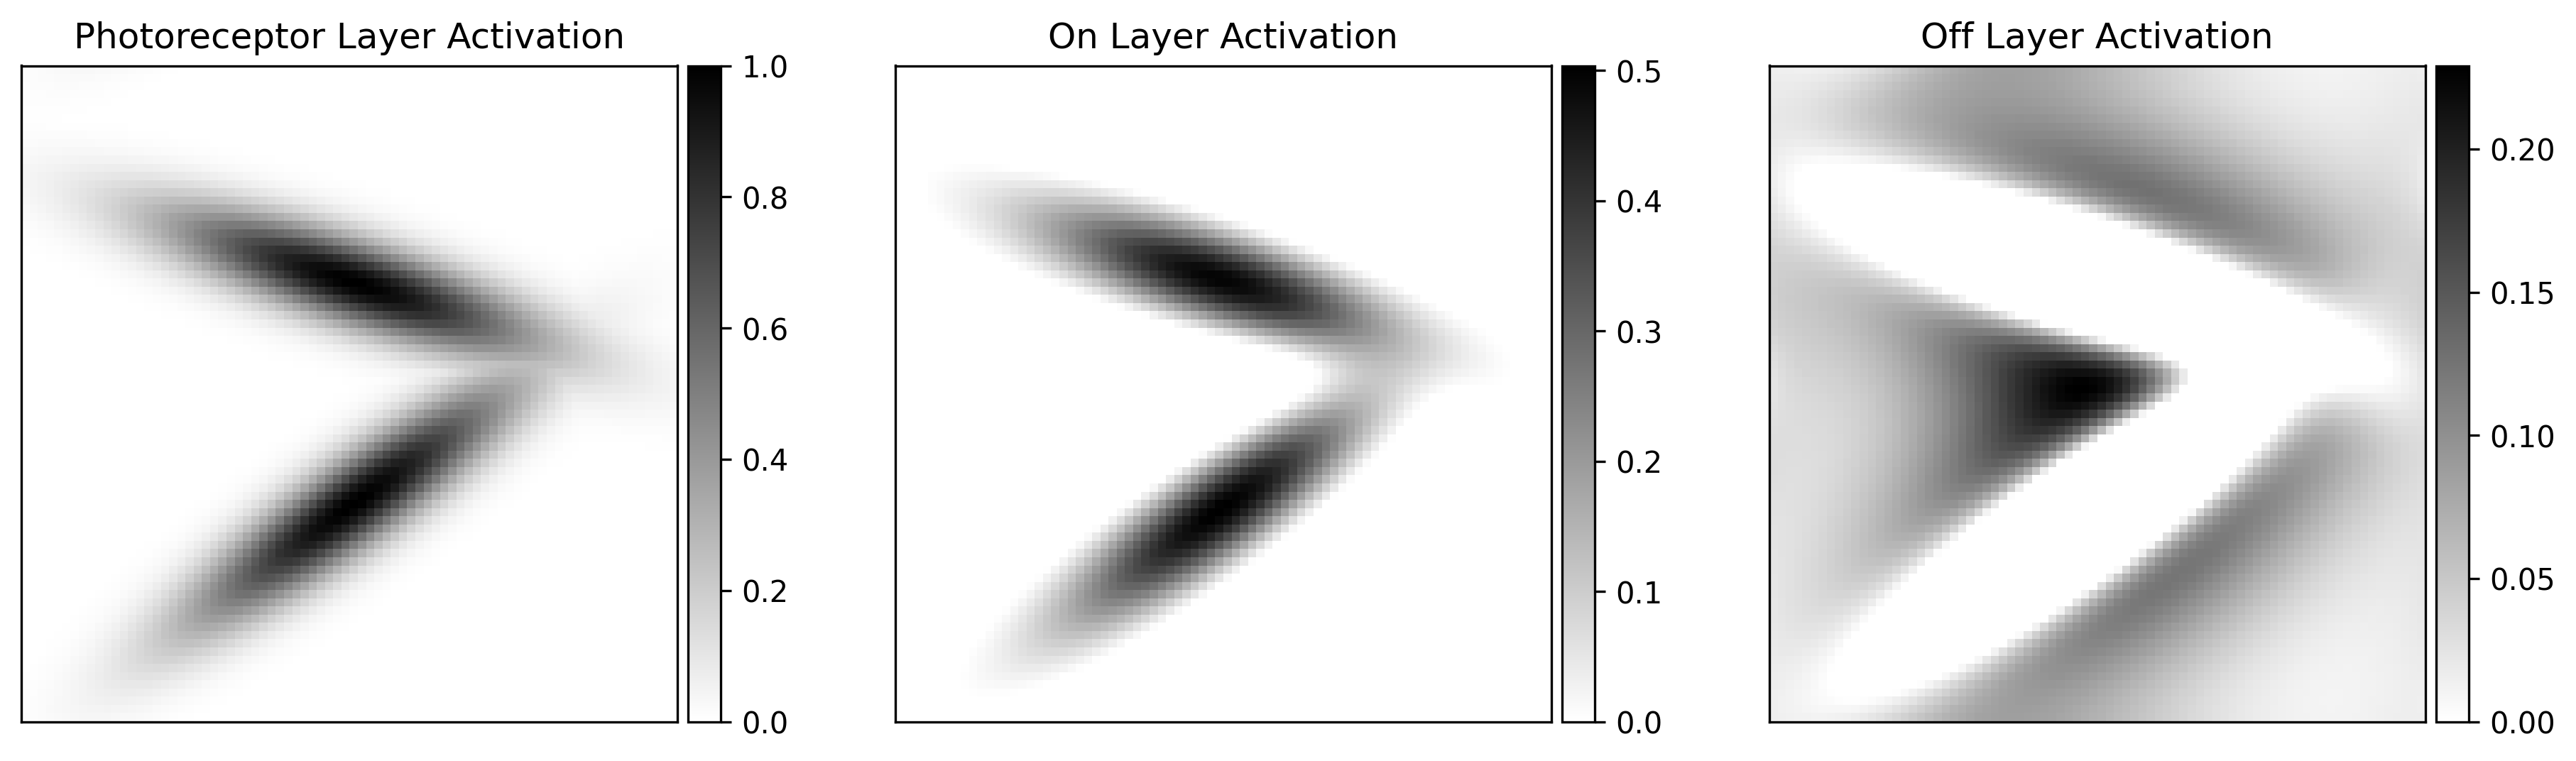

In [11]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(-Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

In [49]:
n_ret_patts = 200
gaus_psis = 0.25*np.stack([stevens_gauss(np.random.default_rng(0).integers(Nret,size=(2*n_ret_patts))[i],
                                    np.random.default_rng(1).integers(Nret,size=(2*n_ret_patts))[i],
                                    np.pi*np.random.default_rng(2).random(size=(2*n_ret_patts))[i]) for i in
                      range(2*n_ret_patts)]).reshape(
    2,n_ret_patts,Nret**2)
gaus_psis = np.fmax(gaus_psis[0],gaus_psis[1])
unif_psis = np.random.default_rng(0).random(size=(n_ret_patts,Nret**2))
norm_psis = np.random.default_rng(0).normal(size=(n_ret_patts,Nret**2))

In [50]:
gaus_Wpsis = np.einsum('ij,kj->ki',WRtoT,gaus_psis)
unif_Wpsis = np.einsum('ij,kj->ki',WRtoT,unif_psis)
norm_Wpsis = np.einsum('ij,kj->ki',WRtoT,norm_psis)

Text(0.5, 1.0, 'Input to LGN Histogram')

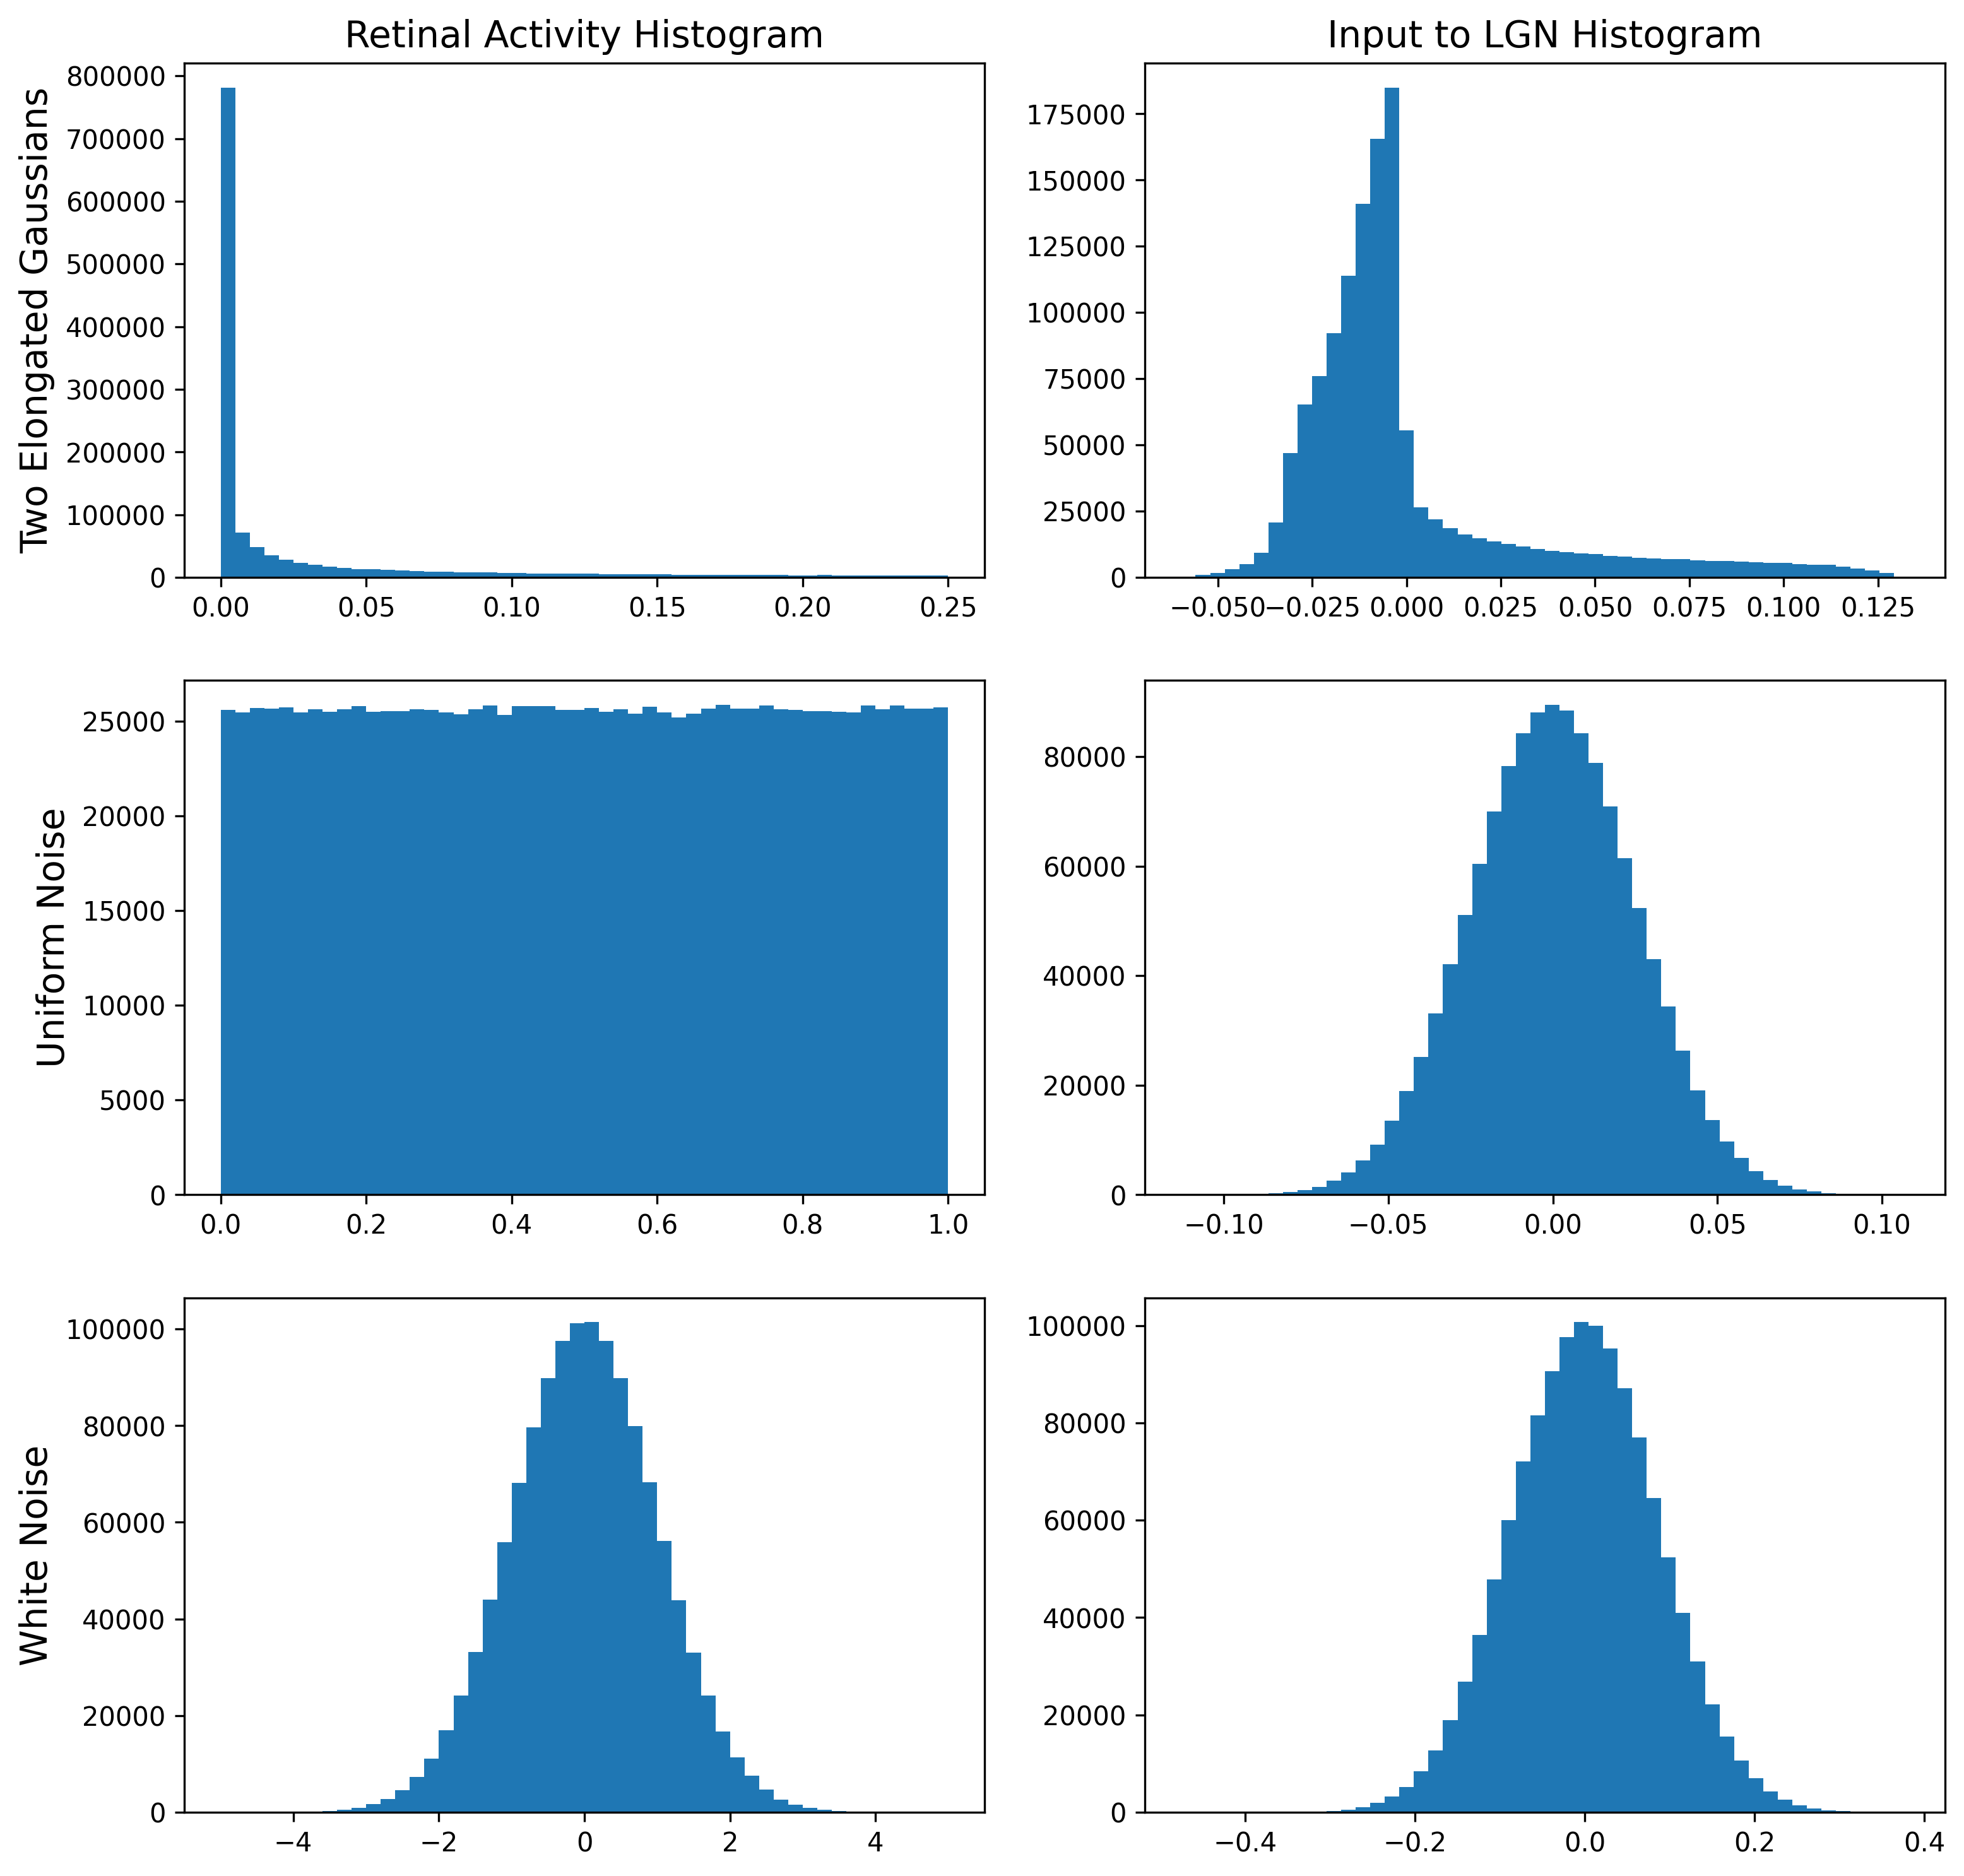

In [51]:
fig,axs = plt.subplots(3,2,figsize=(12,12),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_psis.flatten(),50)
axs[0,1].hist(gaus_Wpsis.flatten(),50)
axs[1,0].hist(unif_psis.flatten(),50)
axs[1,1].hist(unif_Wpsis.flatten(),50)
axs[2,0].hist(norm_psis.flatten(),50)
axs[2,1].hist(norm_Wpsis.flatten(),50)

axs[0,0].set_ylabel('Two Elongated Gaussians',fontsize=14)
axs[1,0].set_ylabel('Uniform Noise',fontsize=14)
axs[2,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('Retinal Activity Histogram',fontsize=14)
axs[0,1].set_title('Input to LGN Histogram',fontsize=14)

In [52]:
print(np.std(gaus_Wpsis.flatten()))
print(np.std(unif_Wpsis.flatten()))
print(np.std(norm_Wpsis.flatten()))

0.03153864062628523
0.02500214510383747
0.08645184165611053


## Create LGN Activity Patterns

In [72]:
gaus_N_act = fio_rect(14*gaus_Wpsis)
gaus_F_act = fio_rect(14*-gaus_Wpsis)

unif_N_act = fio_rect(17*unif_Wpsis)
unif_F_act = fio_rect(17*-unif_Wpsis)

norm_N_act = fio_rect(5*norm_Wpsis)
norm_F_act = fio_rect(5*-norm_Wpsis)

Text(0.5, 1.0, 'Off Cell Activity Histogram')

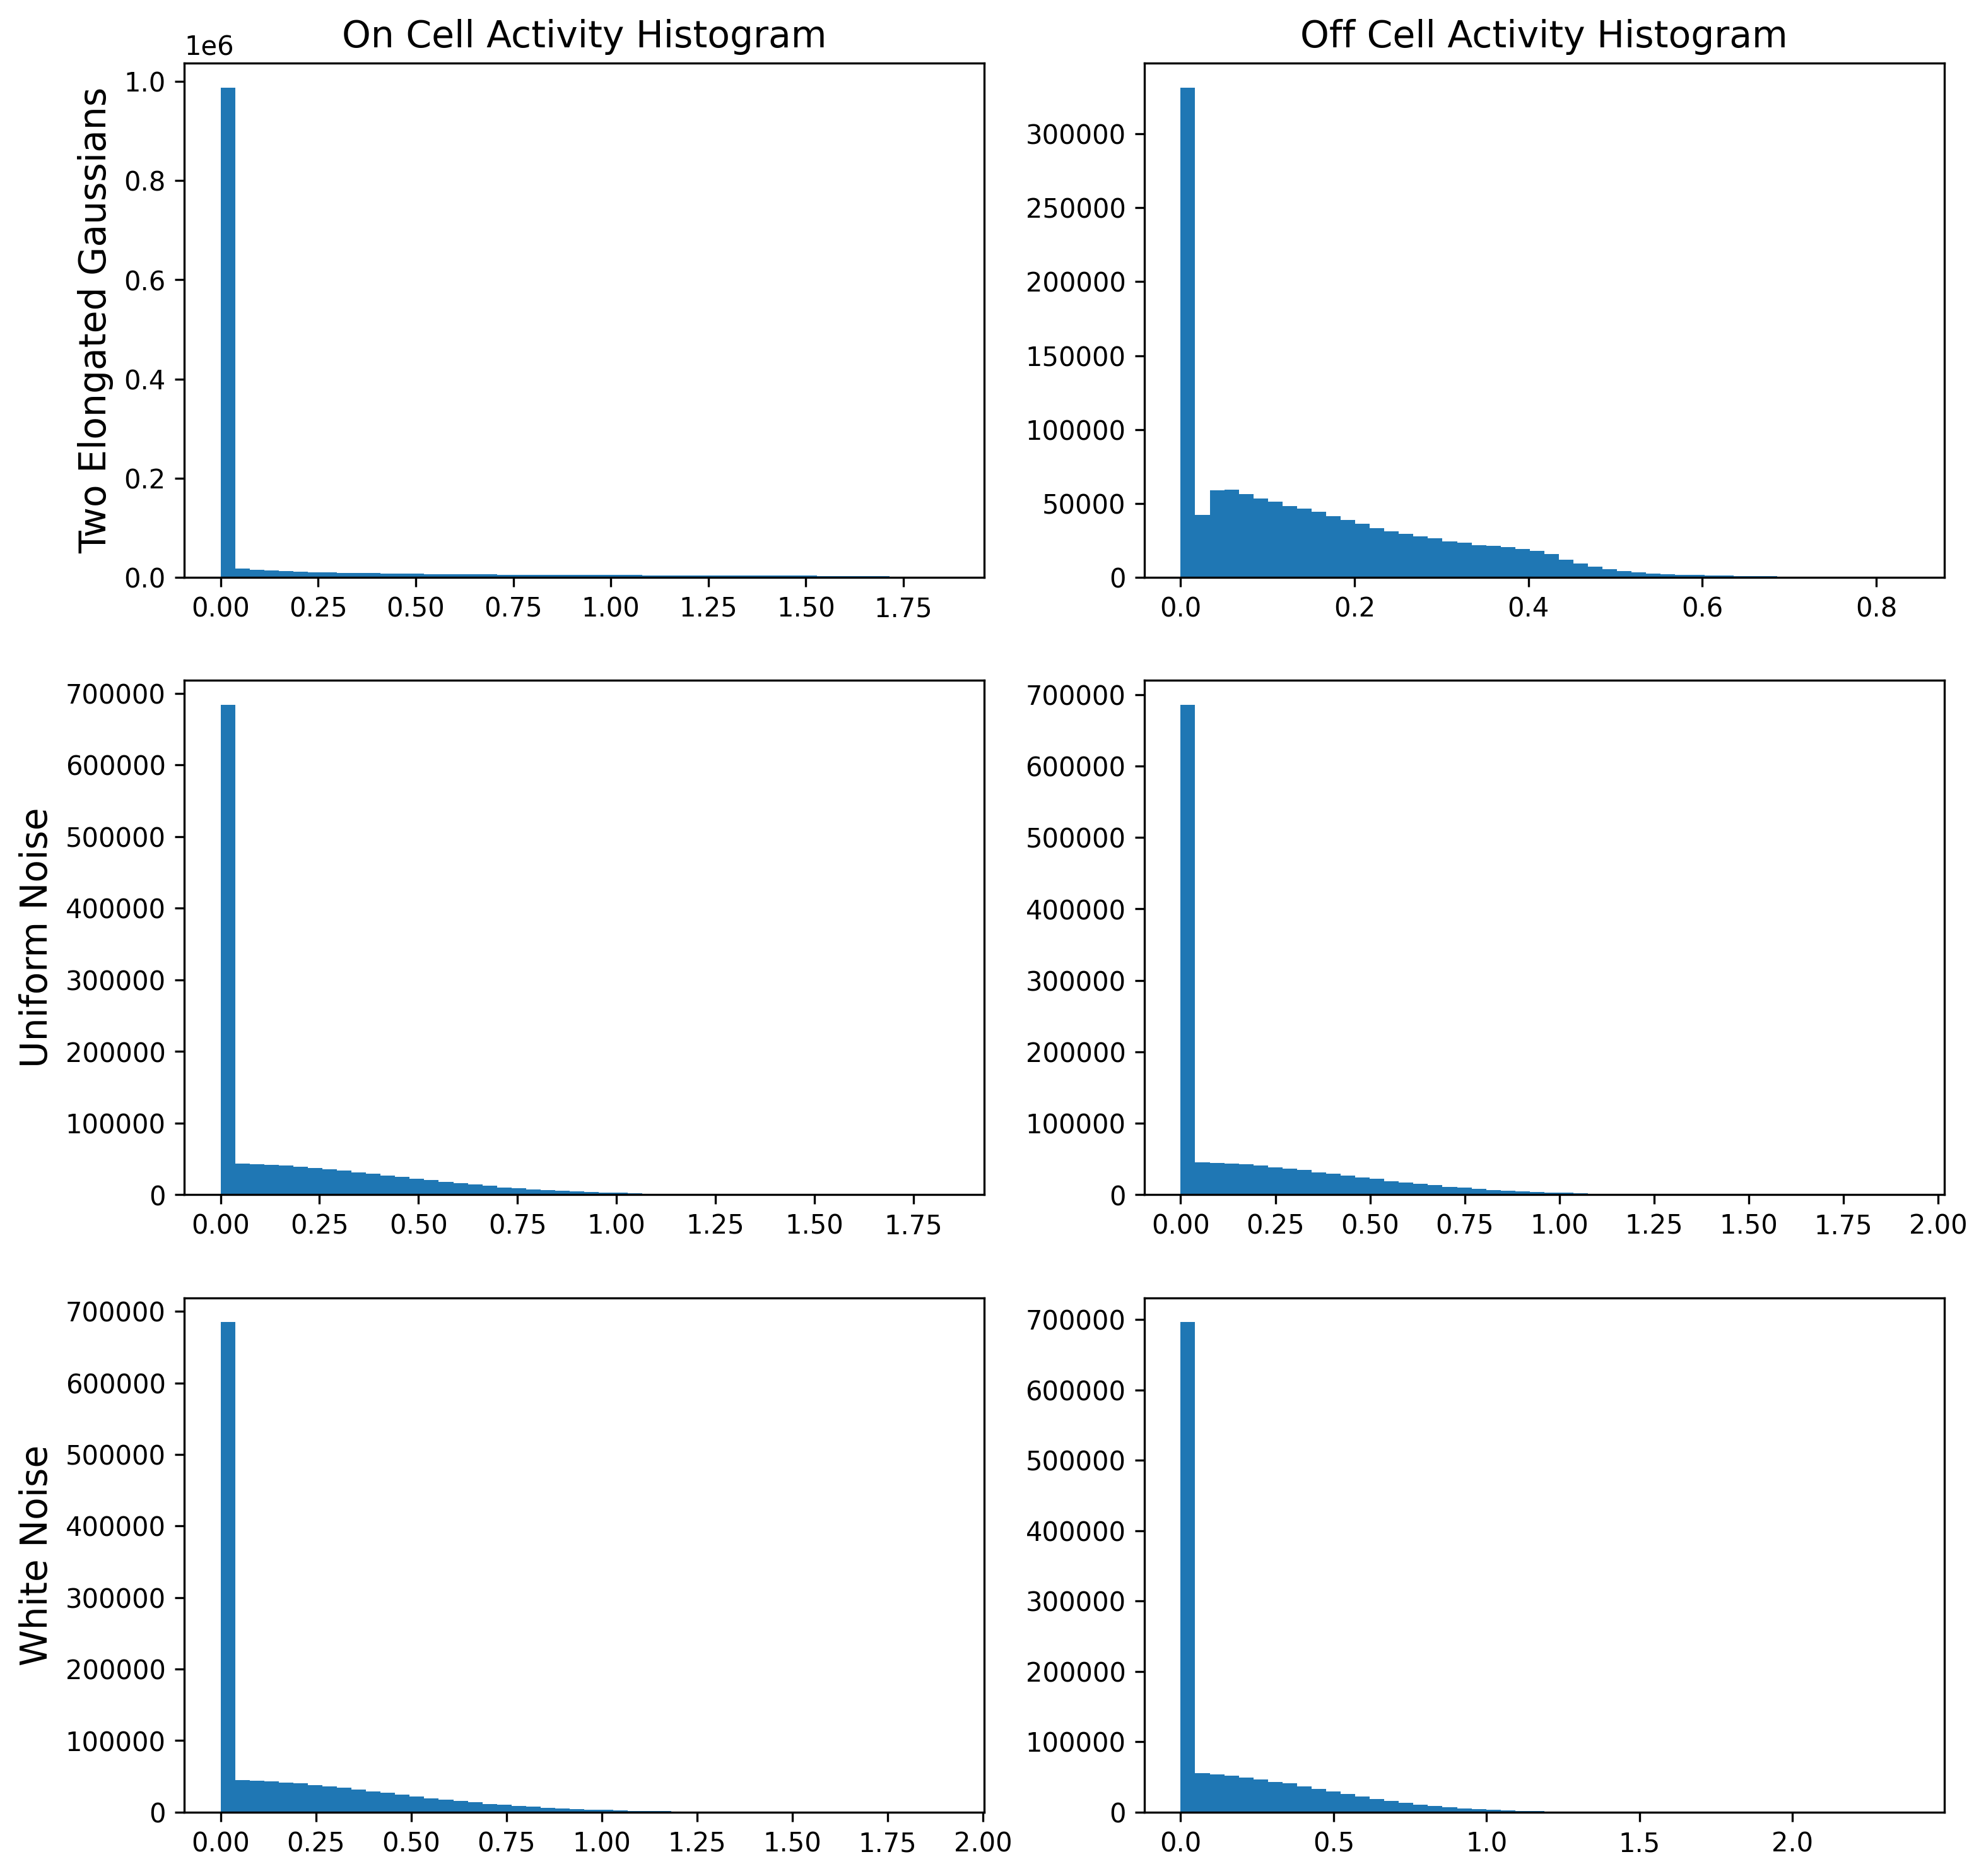

In [73]:
fig,axs = plt.subplots(3,2,figsize=(12,12),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_N_act.flatten(),50)
axs[0,1].hist(gaus_F_act.flatten(),50)
axs[1,0].hist(unif_N_act.flatten(),50)
axs[1,1].hist(unif_F_act.flatten(),50)
axs[2,0].hist(norm_N_act.flatten(),50)
axs[2,1].hist(norm_F_act.flatten(),50)

axs[0,0].set_ylabel('Two Elongated Gaussians',fontsize=14)
axs[1,0].set_ylabel('Uniform Noise',fontsize=14)
axs[2,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('On Cell Activity Histogram',fontsize=14)
axs[0,1].set_title('Off Cell Activity Histogram',fontsize=14)

## Calculate Spatial Correlations

In [74]:
gaus_full_cov = np.cov(gaus_N_act.T,gaus_F_act.T)
gaus_NN_cov = gaus_full_cov[:N**2,:N**2]
gaus_NF_cov = gaus_full_cov[:N**2,N**2:]
gaus_FN_cov = gaus_full_cov[N**2:,:N**2]
gaus_FF_cov = gaus_full_cov[N**2:,N**2:]

unif_full_cov = np.cov(unif_N_act.T,unif_F_act.T)
unif_NN_cov = unif_full_cov[:N**2,:N**2]
unif_NF_cov = unif_full_cov[:N**2,N**2:]
unif_FN_cov = unif_full_cov[N**2:,:N**2]
unif_FF_cov = unif_full_cov[N**2:,N**2:]

norm_full_cov = np.cov(norm_N_act.T,norm_F_act.T)
norm_NN_cov = norm_full_cov[:N**2,:N**2]
norm_NF_cov = norm_full_cov[:N**2,N**2:]
norm_FN_cov = norm_full_cov[N**2:,:N**2]
norm_FF_cov = norm_full_cov[N**2:,N**2:]

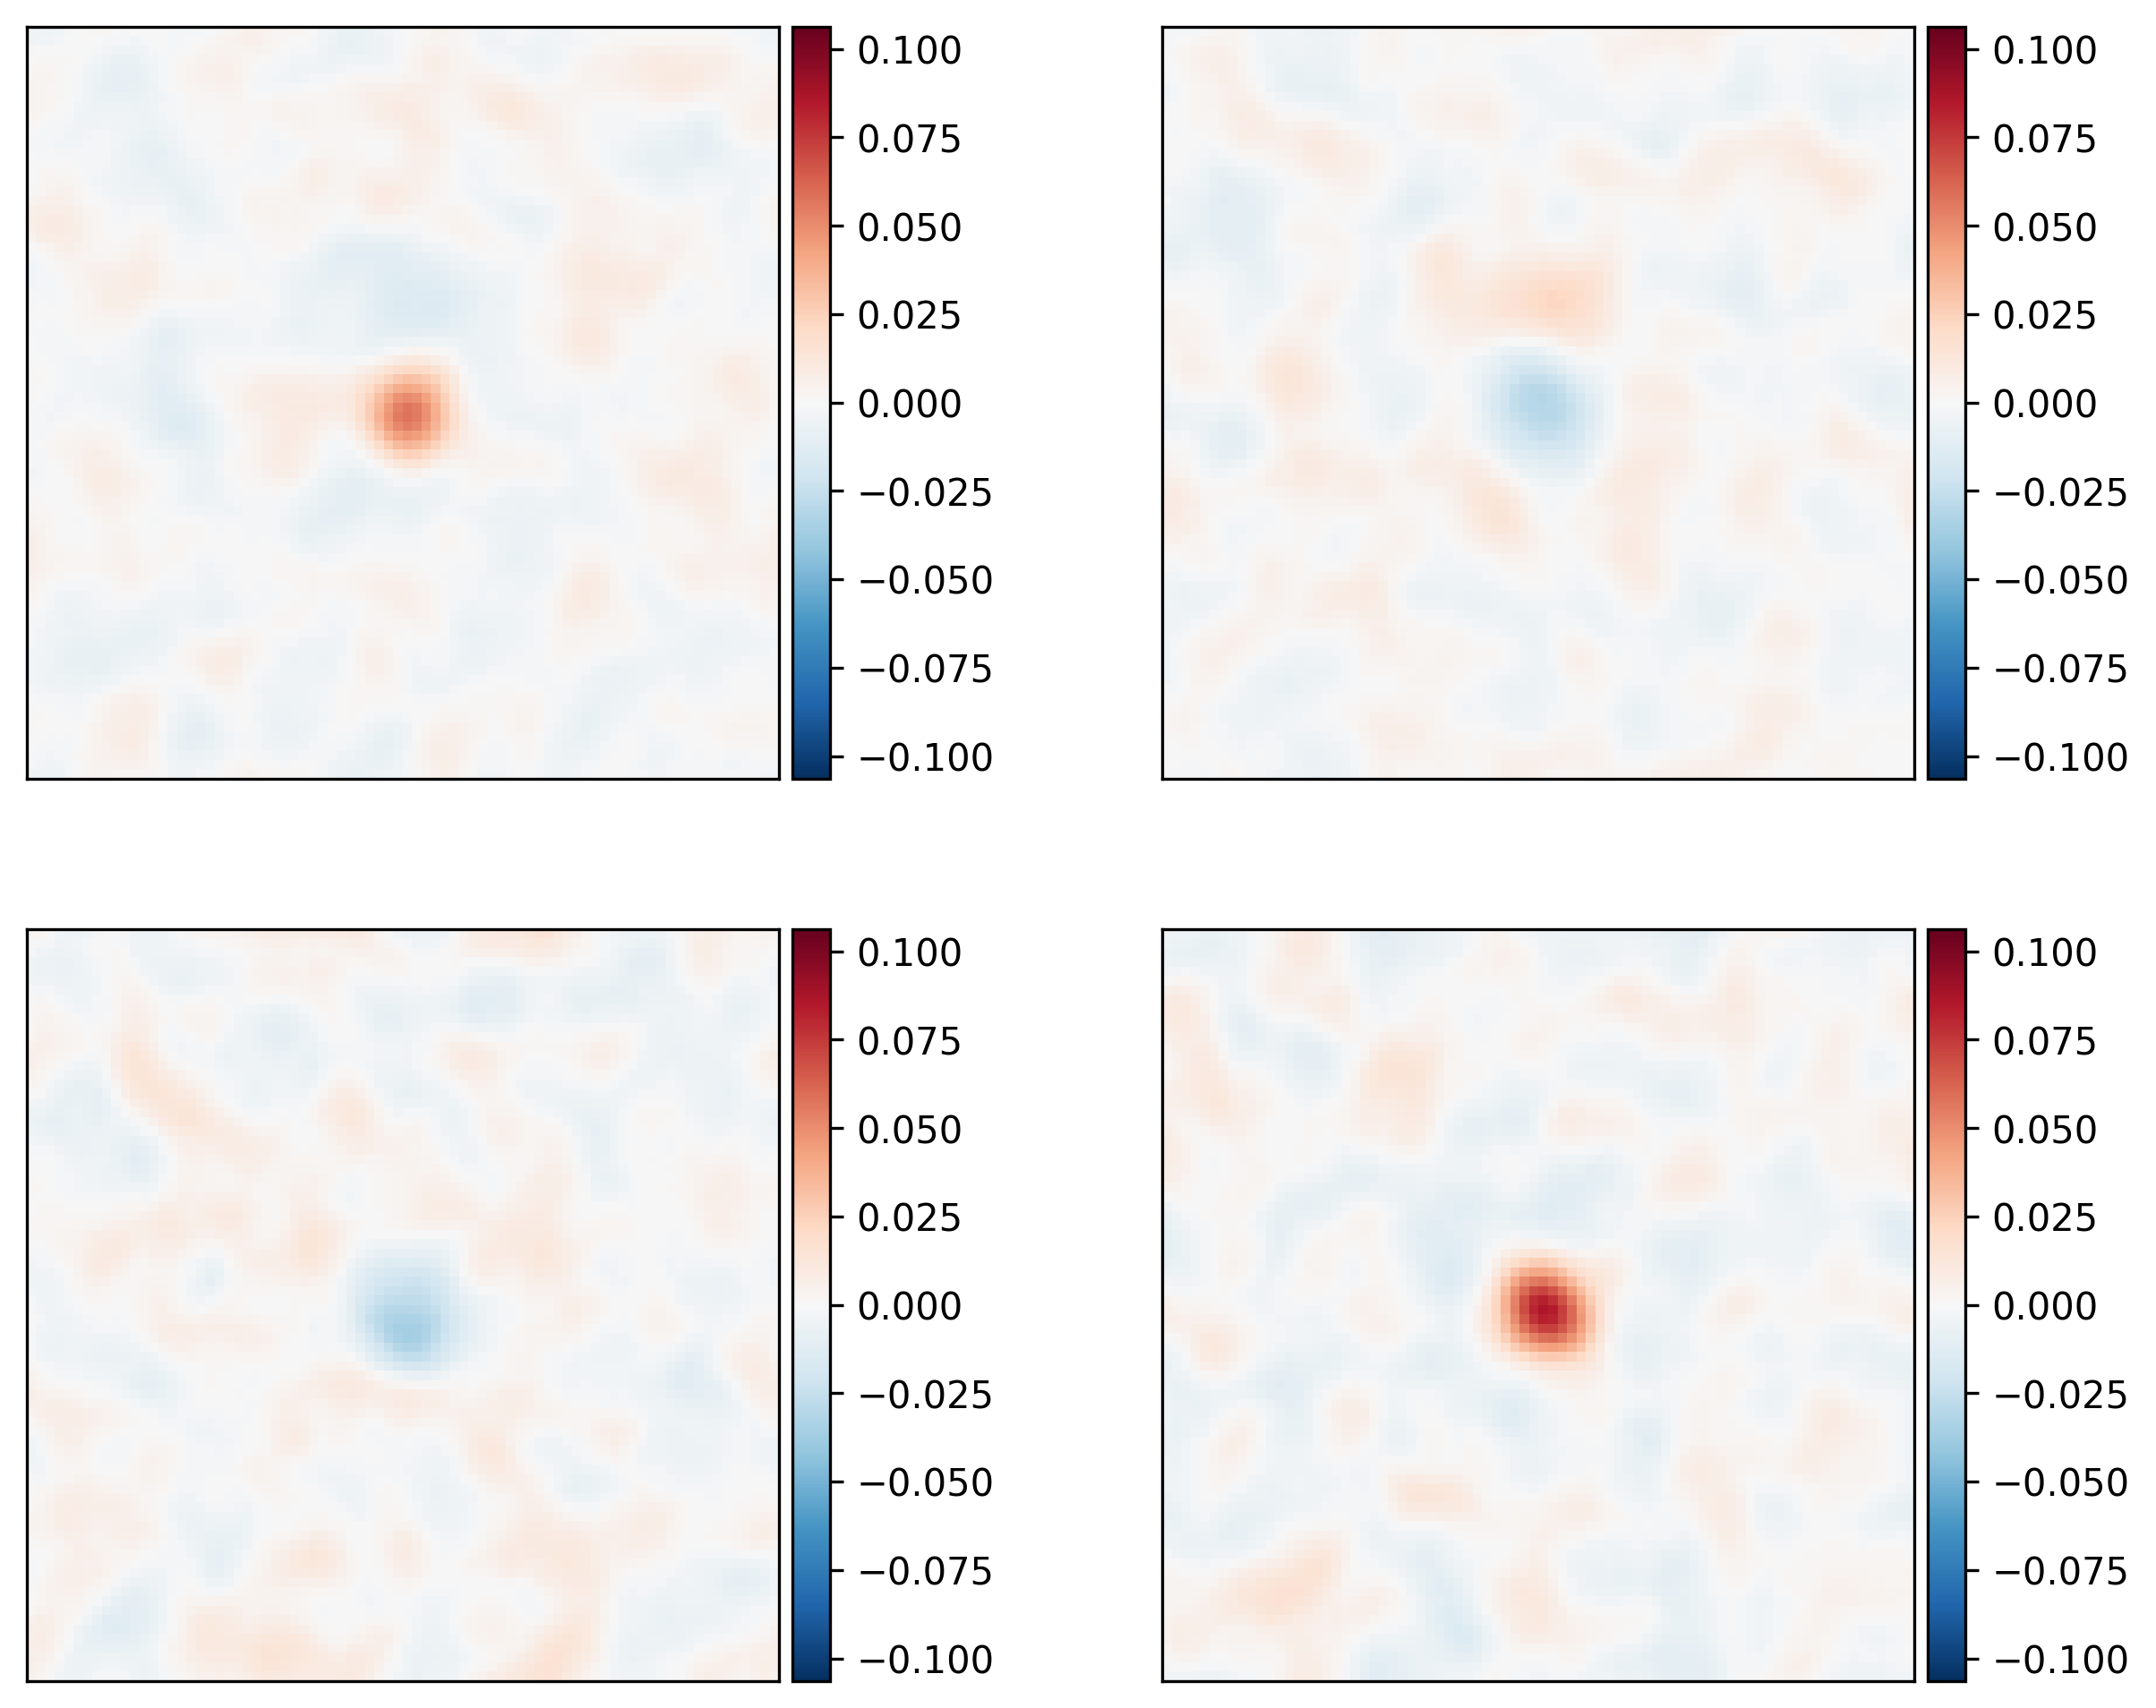

In [75]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = np.max(np.abs(norm_full_cov))

pf.imshowbar(fig,axs[0,0],norm_NN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[0,1],norm_NF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,0],norm_FN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,1],norm_FF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)

In [76]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

gaus_SN_cov = np.zeros(72)
gaus_SN_cov_err = np.zeros(72)
gaus_SF_cov = np.zeros(72)
gaus_SF_cov_err = np.zeros(72)
gaus_D_cov = np.zeros(72)
gaus_D_cov_err = np.zeros(72)

norm_S_cov = np.zeros(72)
norm_S_cov_err = np.zeros(72)
norm_D_cov = np.zeros(72)
norm_D_cov_err = np.zeros(72)

for idx in range(72):
    gaus_SN_cov[idx] = np.mean(gaus_NN_cov[bin_idxs == idx])
    gaus_SN_cov_err[idx] = np.sqrt(np.var(gaus_NN_cov[bin_idxs == idx]))
    gaus_SF_cov[idx] = np.mean(gaus_FF_cov[bin_idxs == idx])
    gaus_SF_cov_err[idx] = np.sqrt(np.var(gaus_FF_cov[bin_idxs == idx]))
    gaus_D_cov[idx] = 0.5*(np.mean(gaus_NF_cov[bin_idxs == idx]) + np.mean(gaus_NF_cov[bin_idxs == idx]))
    gaus_D_cov_err[idx] = np.sqrt(np.var(gaus_NF_cov[bin_idxs == idx]) + np.var(gaus_NF_cov[bin_idxs == idx]))
    
    norm_S_cov[idx] = 0.5*(np.mean(norm_NN_cov[bin_idxs == idx]) + np.mean(norm_FF_cov[bin_idxs == idx]))
    norm_S_cov_err[idx] = np.sqrt(np.var(norm_NN_cov[bin_idxs == idx]) + np.var(norm_FF_cov[bin_idxs == idx]))
    norm_D_cov[idx] = 0.5*(np.mean(norm_NF_cov[bin_idxs == idx]) + np.mean(norm_NF_cov[bin_idxs == idx]))
    norm_D_cov_err[idx] = np.sqrt(np.var(norm_NF_cov[bin_idxs == idx]) + np.var(norm_NF_cov[bin_idxs == idx]))

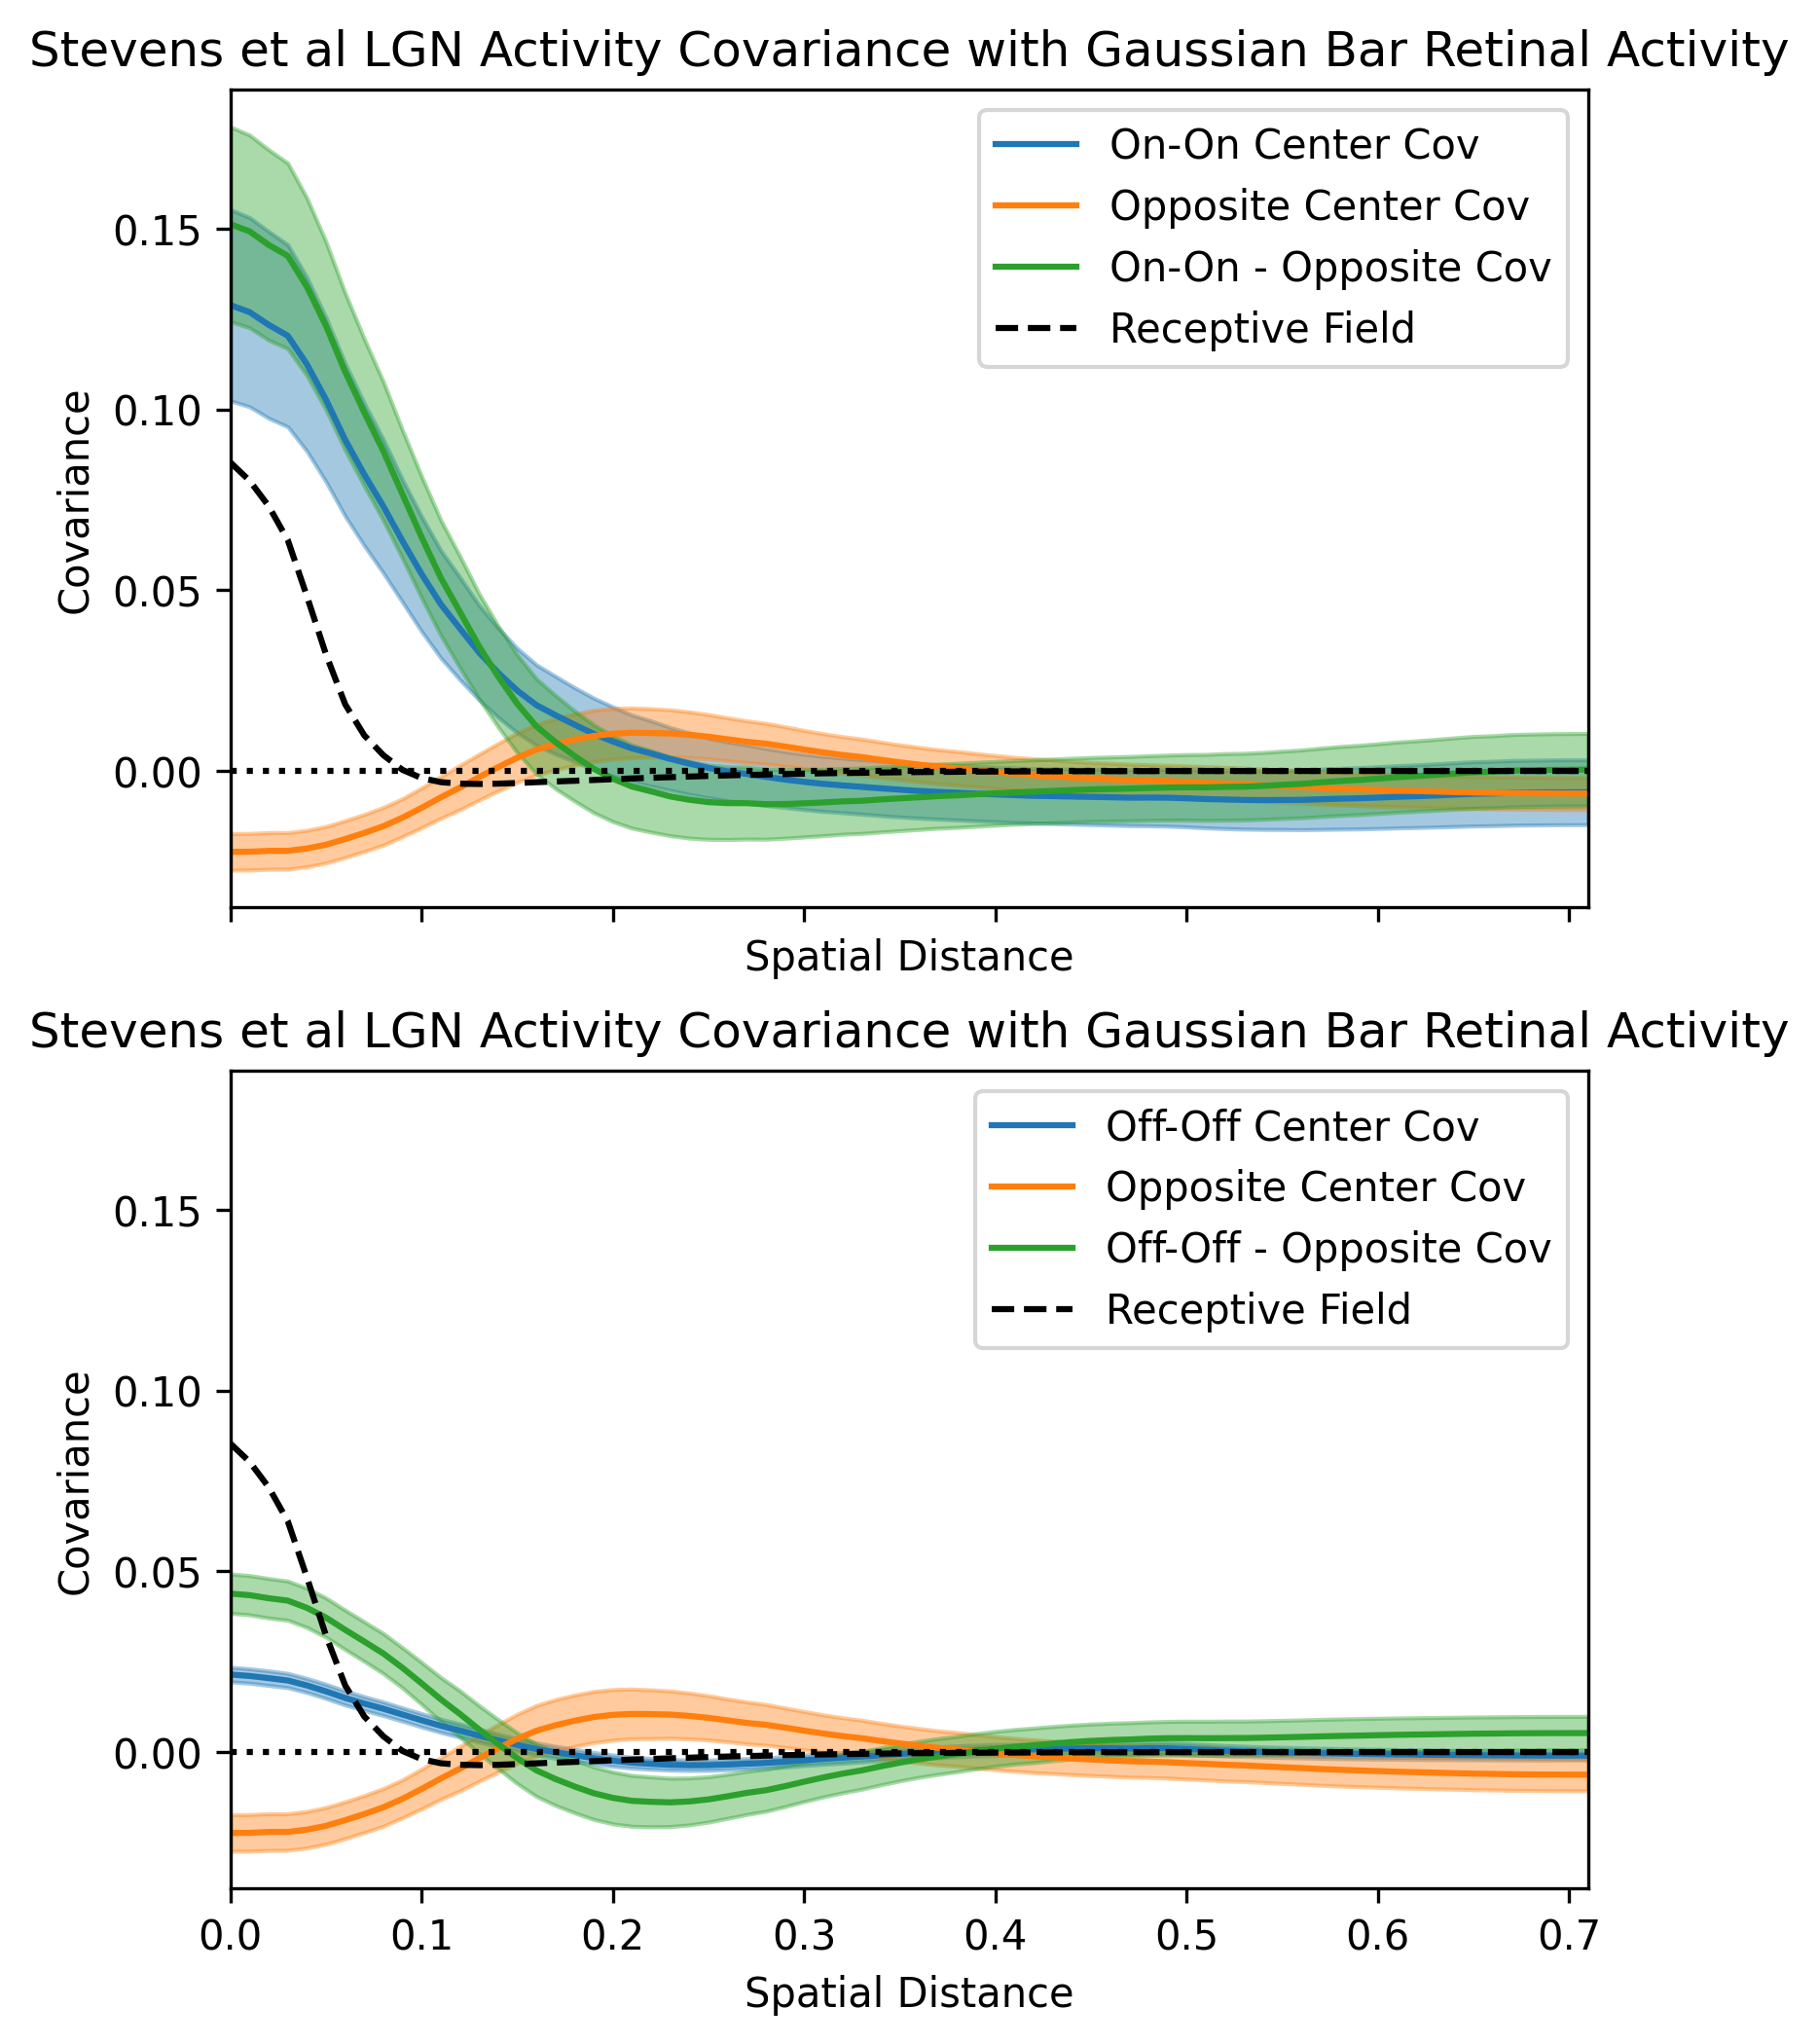

In [77]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,gaus_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C0',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C0',alpha=0.4)
axs[0].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[1].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[0].plot(dists,gaus_SN_cov-gaus_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_D_cov-np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),
                 gaus_SN_cov-gaus_D_cov+np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov-gaus_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_D_cov-np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),
                 gaus_SF_cov-gaus_D_cov+np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)

for i in range(2):
    
    axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
    axs[i].axhline(0,c='k',ls=':')
    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    axs[i].set_title('Stevens et al LGN Activity Covariance with Gaussian Bar Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

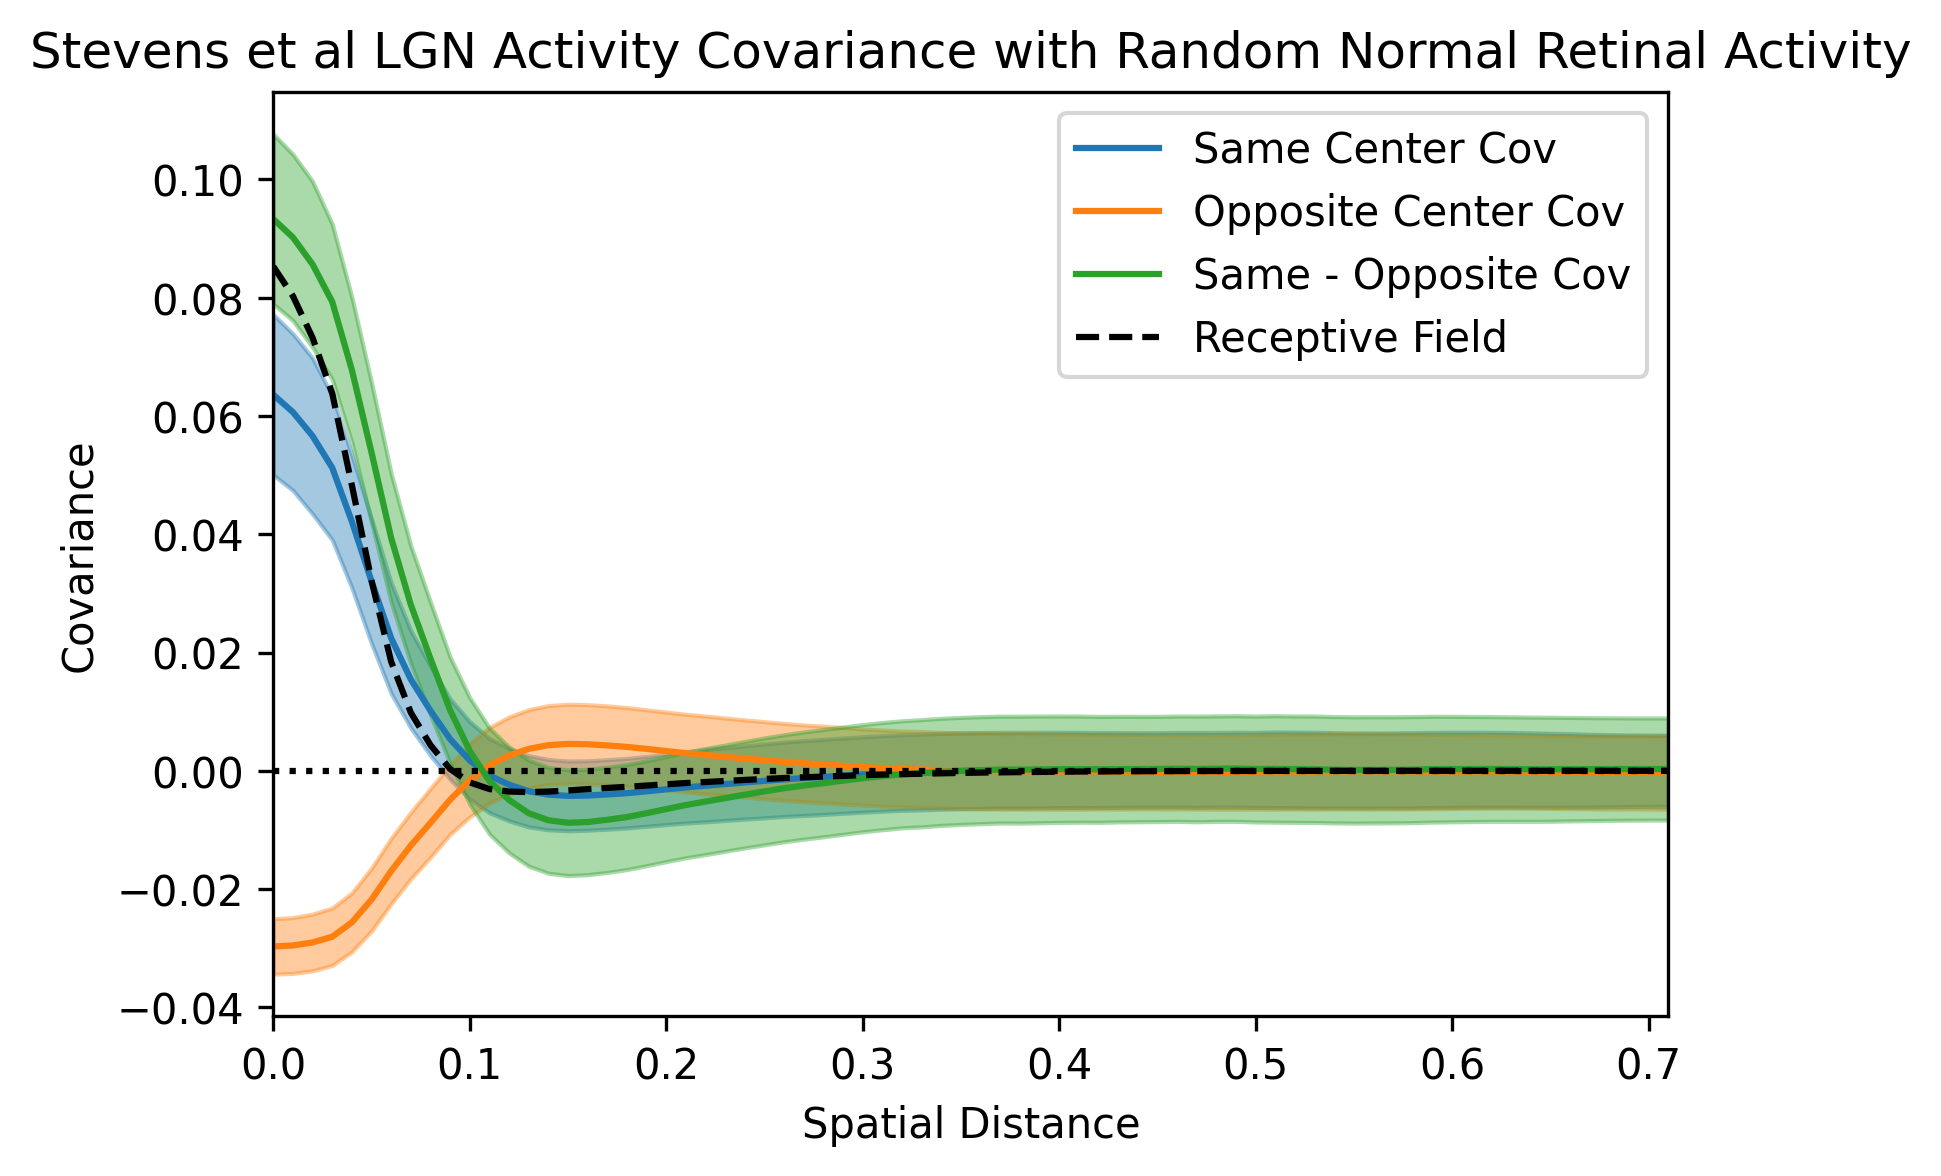

In [63]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,norm_S_cov-norm_S_cov_err,norm_S_cov+norm_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,norm_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,norm_D_cov-norm_D_cov_err,norm_D_cov+norm_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,norm_S_cov-norm_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,norm_S_cov-norm_D_cov-np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),
                 norm_S_cov-norm_D_cov+np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

# Look at Effect of Gain Control

In [25]:
gcconn_params = {
    'sigma':  0.037,
    'ampl':   1.0,
    'noise':   0.0,
    'profile': 'Gaussian',
    'stevensetal': True
}

In [26]:
reload(connectivity)

conn = connectivity.Connectivity((N,N),(N,N),0)
Wgc,_ = conn.create_matrix(gcconn_params,gcconn_params['profile'])

In [27]:
from scipy.integrate import solve_ivp

def dynamics_system(y,inp_ff,Wrec,gam_o=14.0,gam_s=1.02,k=0.11):
    return fio_rect(gam_o*inp_ff/(k+np.matmul(Wrec,y)))

def integrate(y0,inp,Nt,Wrec,gam_o=14.0,gam_s=1.02,k=0.11):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,Wrec,gam_o,gam_s,k)
        y = out
    return y

Text(0, 0.5, '50% Contrast')

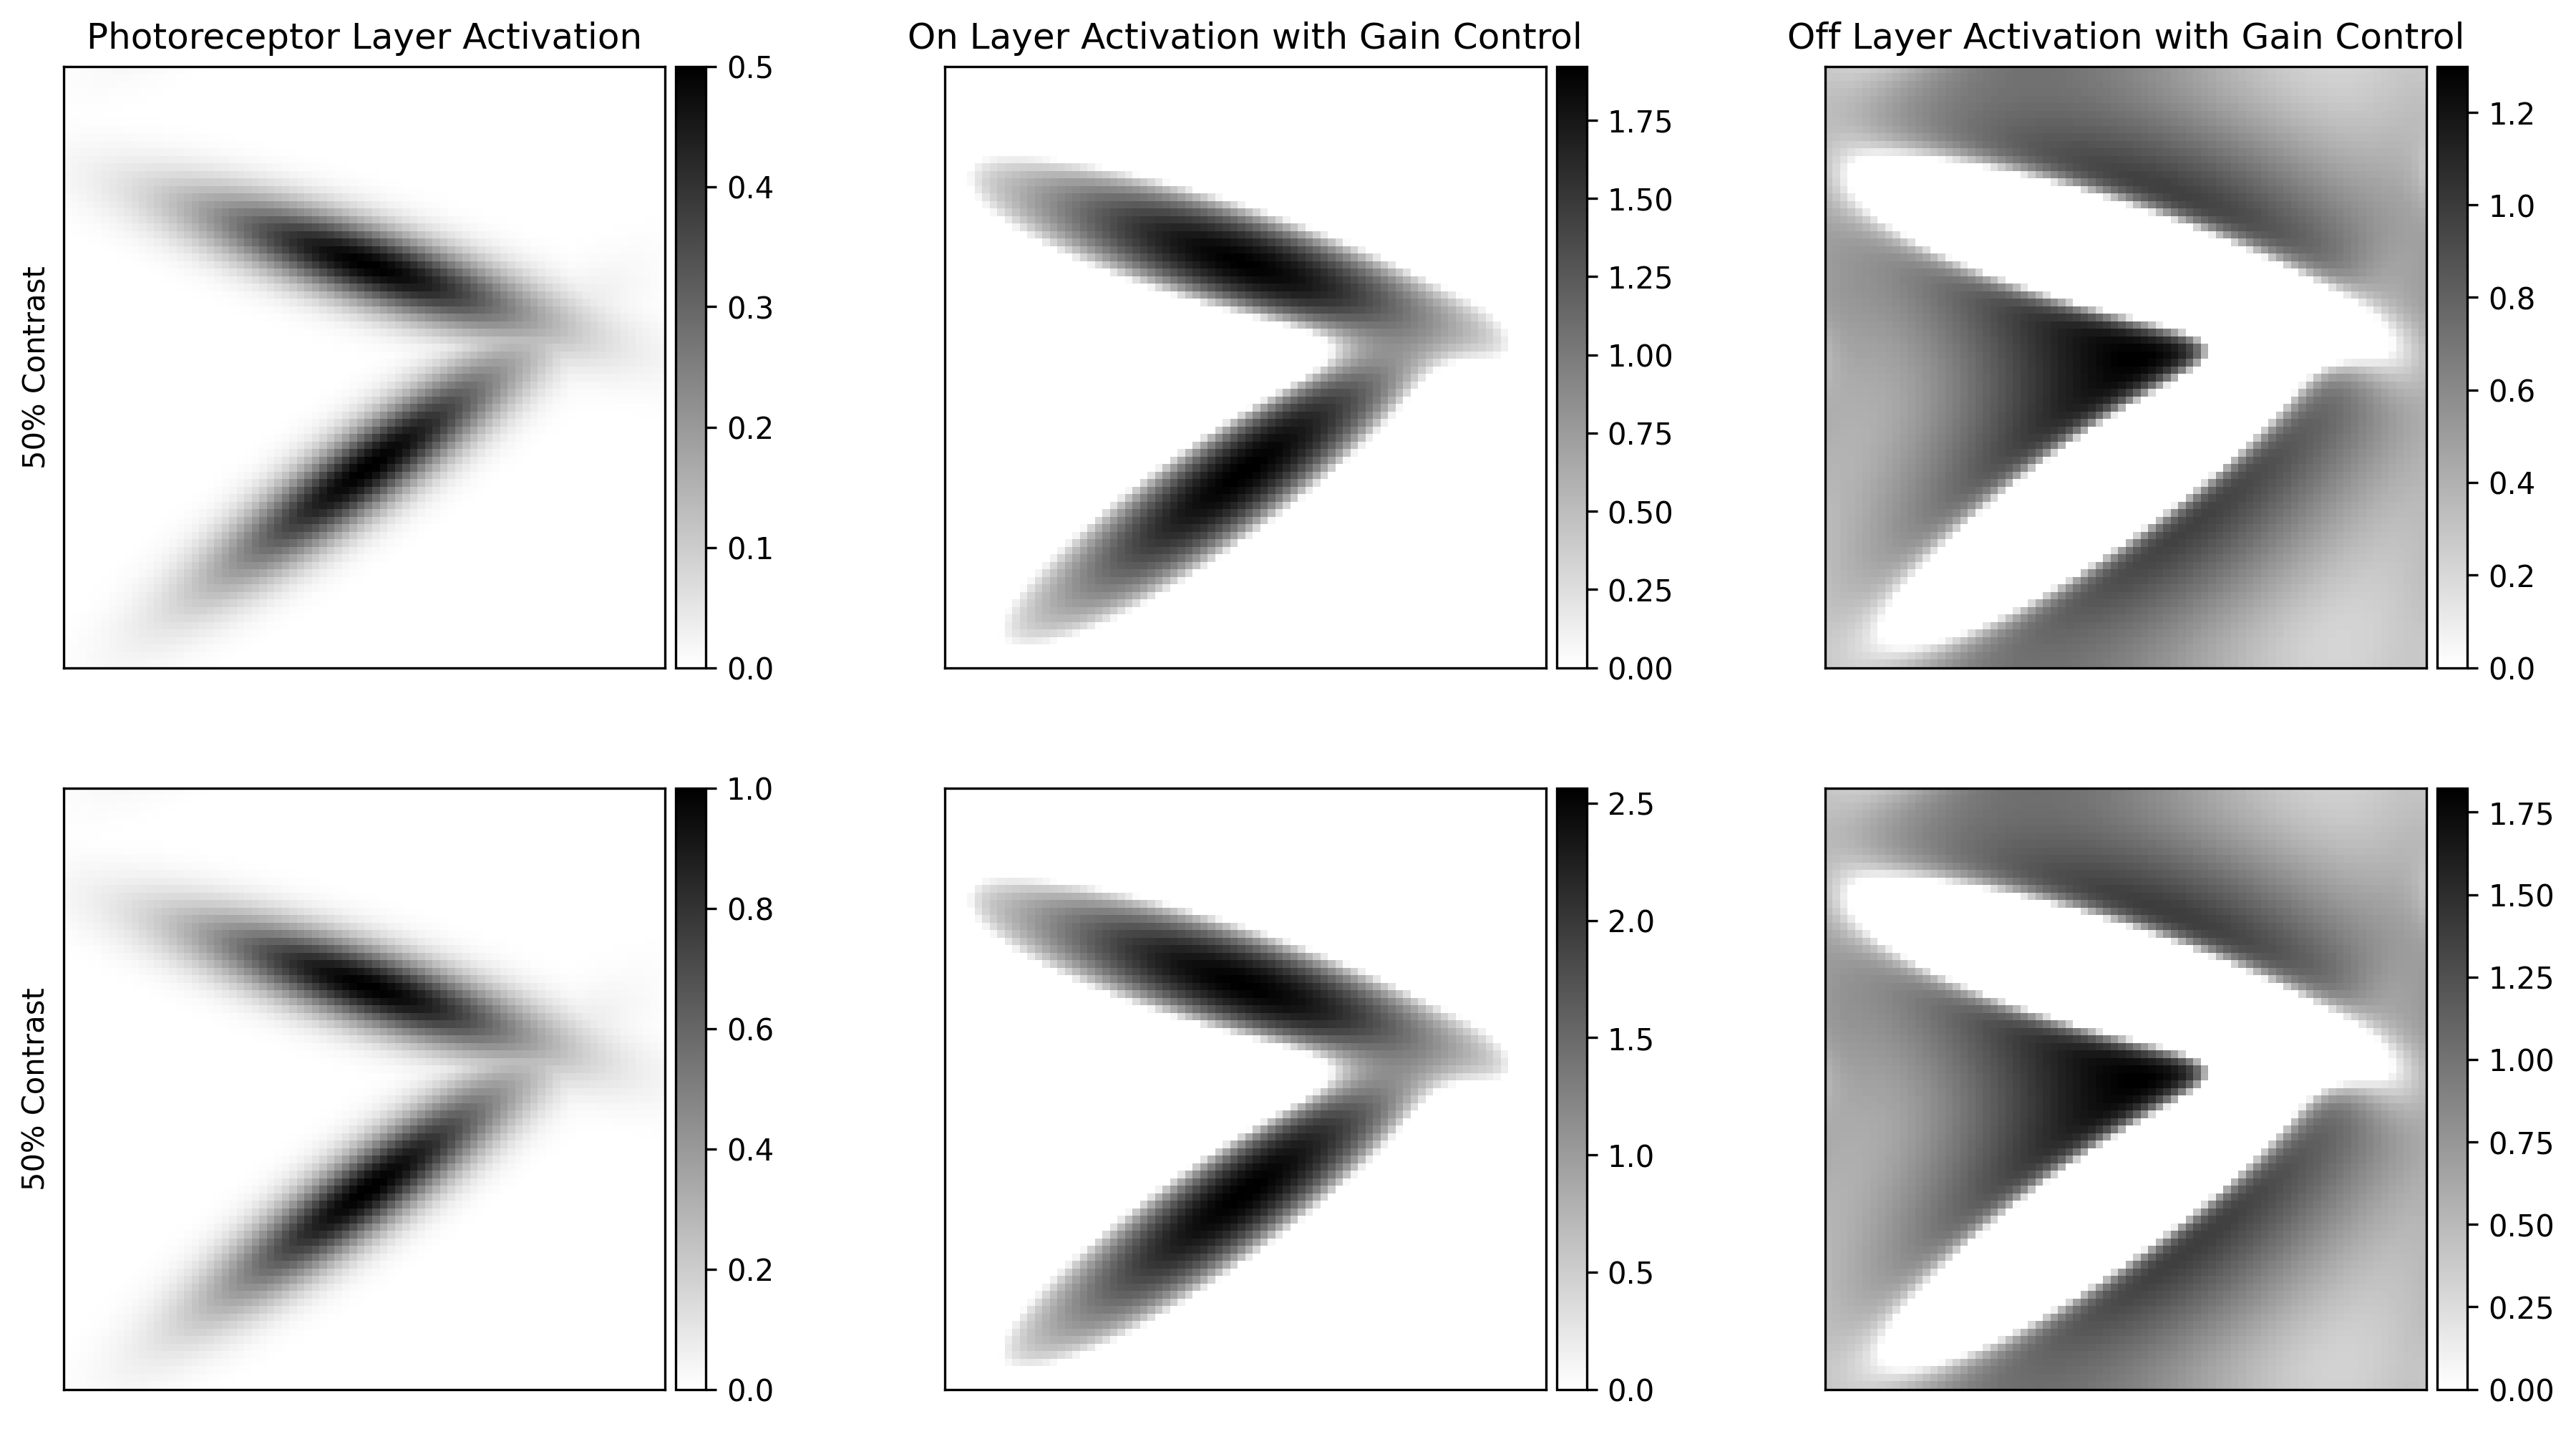

In [64]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=300)

psi = 0.5*np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[0,0],psi,cmap='binary')
pf.imshowbar(fig,axs[0,1],N_act,cmap='binary')
pf.imshowbar(fig,axs[0,2],F_act,cmap='binary')

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[1,0],psi,cmap='binary')
pf.imshowbar(fig,axs[1,1],N_act,cmap='binary')
pf.imshowbar(fig,axs[1,2],F_act,cmap='binary')

axs[0,0].set_title('Photoreceptor Layer Activation')
axs[0,1].set_title('On Layer Activation with Gain Control')
axs[0,2].set_title('Off Layer Activation with Gain Control')

axs[0,0].set_ylabel('50% Contrast')
axs[1,0].set_ylabel('50% Contrast')

Text(0, 0.5, '50% Contrast')

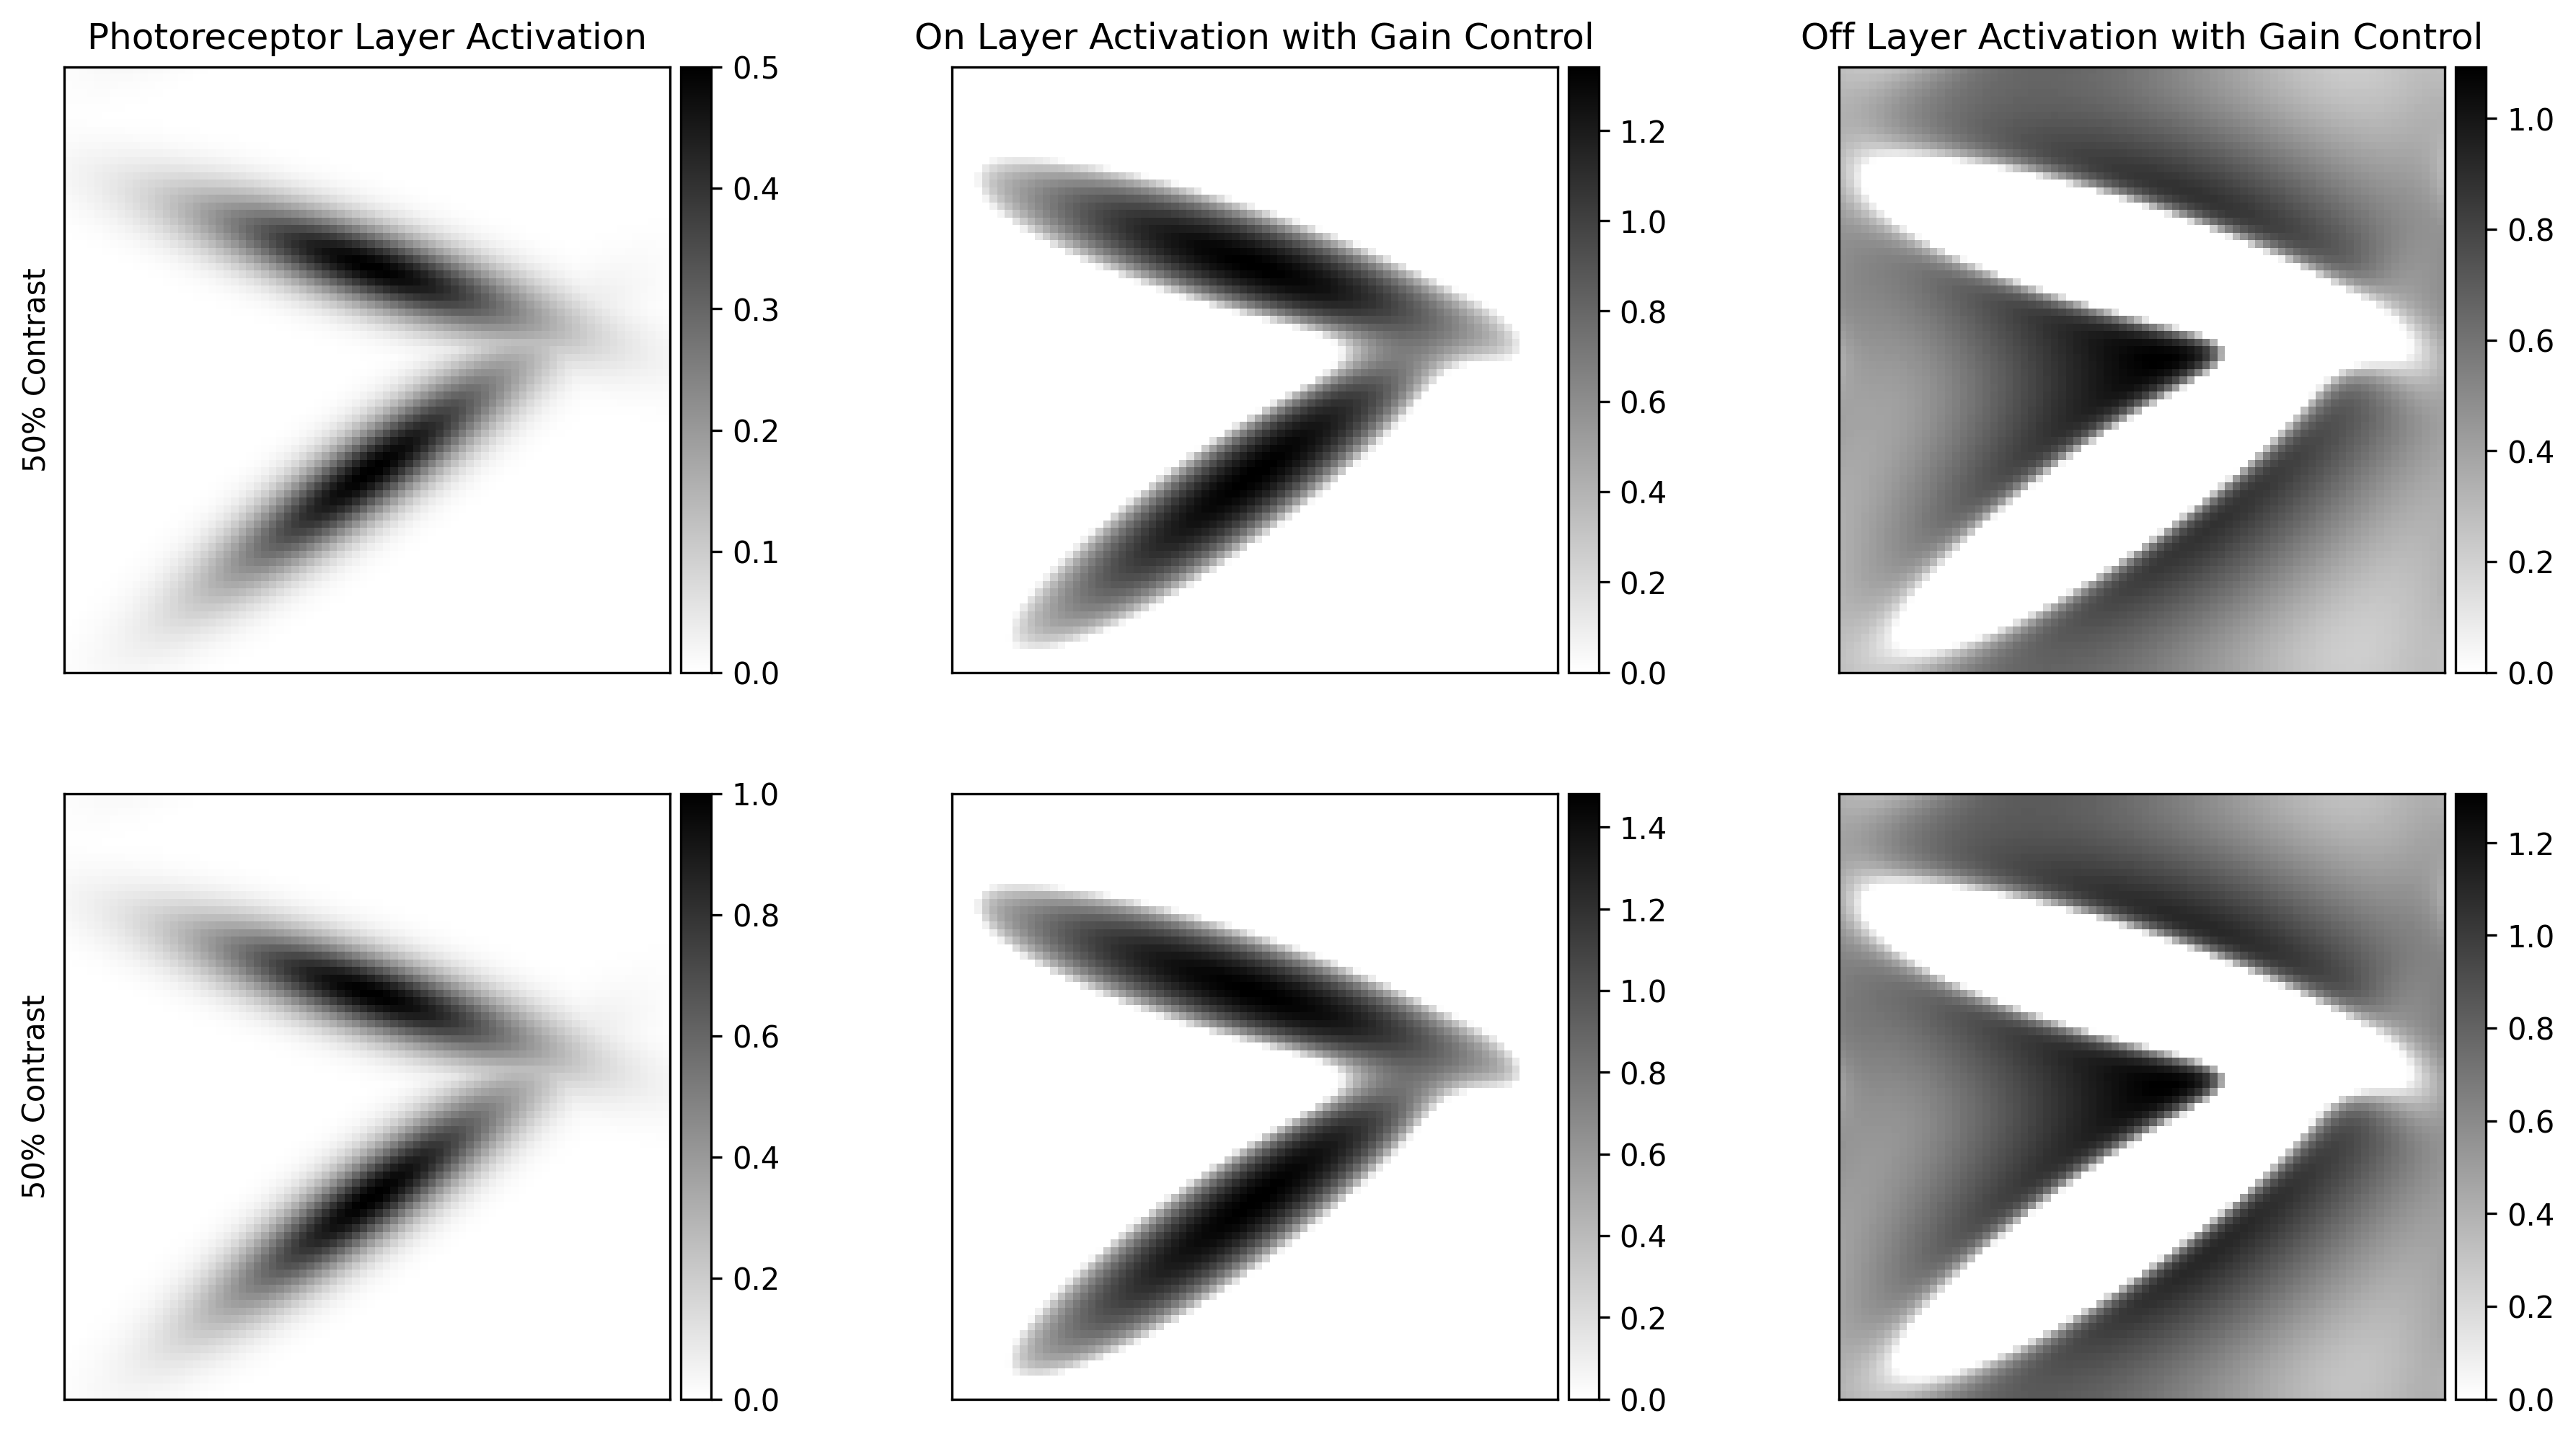

In [78]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=300)

psi = 0.5*np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),20,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),20,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[0,0],psi,cmap='binary')
pf.imshowbar(fig,axs[0,1],N_act,cmap='binary')
pf.imshowbar(fig,axs[0,2],F_act,cmap='binary')

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),20,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),20,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[1,0],psi,cmap='binary')
pf.imshowbar(fig,axs[1,1],N_act,cmap='binary')
pf.imshowbar(fig,axs[1,2],F_act,cmap='binary')

axs[0,0].set_title('Photoreceptor Layer Activation')
axs[0,1].set_title('On Layer Activation with Gain Control')
axs[0,2].set_title('Off Layer Activation with Gain Control')

axs[0,0].set_ylabel('50% Contrast')
axs[1,0].set_ylabel('50% Contrast')

In [65]:
# gaus_N_act = np.zeros_like(gaus_Wpsis)
# gaus_F_act = np.zeros_like(gaus_Wpsis)

# unif_N_act = np.zeros_like(unif_Wpsis)
# unif_F_act = np.zeros_like(unif_Wpsis)

# norm_N_act = np.zeros_like(norm_Wpsis)
# norm_F_act = np.zeros_like(norm_Wpsis)

# for i in range(n_ret_patts):
#     start = time.process_time()
#     gaus_N_act[i] = integrate(np.zeros(Nret**2),gaus_Wpsis[i],50,Wgc)
#     gaus_F_act[i] = integrate(np.zeros(Nret**2),-gaus_Wpsis[i],50,Wgc)
    
#     unif_N_act[i] = integrate(np.zeros(Nret**2),unif_Wpsis[i],50,Wgc,17)
#     unif_F_act[i] = integrate(np.zeros(Nret**2),-unif_Wpsis[i],50,Wgc,17)
    
#     norm_N_act[i] = integrate(np.zeros(Nret**2),norm_Wpsis[i],50,Wgc,5)
#     norm_F_act[i] = integrate(np.zeros(Nret**2),-norm_Wpsis[i],50,Wgc,5)
    
#     print('integrating retinal pattern #',i,'took',time.process_time()-start)
    
# np.save('gaus_N_act.npy',gaus_N_act)
# np.save('gaus_F_act.npy',gaus_F_act)
# np.save('unif_N_act.npy',unif_N_act)
# np.save('unif_F_act.npy',unif_F_act)
# np.save('norm_N_act.npy',norm_N_act)
# np.save('norm_F_act.npy',norm_F_act)
    
gaus_N_act = np.load('gaus_N_act.npy')
gaus_F_act = np.load('gaus_F_act.npy')
unif_N_act = np.load('unif_N_act.npy')
unif_F_act = np.load('unif_F_act.npy')
norm_N_act = np.load('norm_N_act.npy')
norm_F_act = np.load('norm_F_act.npy')

integrating retinal pattern # 0 took 20.124025999999503
integrating retinal pattern # 1 took 20.936123000000407
integrating retinal pattern # 2 took 19.50304000000051
integrating retinal pattern # 3 took 23.166830000000118
integrating retinal pattern # 4 took 21.26848599999994
integrating retinal pattern # 5 took 19.815526000000318
integrating retinal pattern # 6 took 19.602296000000024
integrating retinal pattern # 7 took 20.221974000000046
integrating retinal pattern # 8 took 19.948421000000053
integrating retinal pattern # 9 took 19.97519900000043
integrating retinal pattern # 10 took 20.106964999999946
integrating retinal pattern # 11 took 20.048322999999982
integrating retinal pattern # 12 took 19.561792000000423
integrating retinal pattern # 13 took 19.679349000000002
integrating retinal pattern # 14 took 20.18802599999981
integrating retinal pattern # 15 took 19.95486599999913
integrating retinal pattern # 16 took 19.518592000000353
integrating retinal pattern # 17 took 19.49216

integrating retinal pattern # 145 took 16.441939000000275
integrating retinal pattern # 146 took 16.420790999999554
integrating retinal pattern # 147 took 16.44086199999947
integrating retinal pattern # 148 took 16.47317000000021
integrating retinal pattern # 149 took 16.425226999999722
integrating retinal pattern # 150 took 16.6214659999996
integrating retinal pattern # 151 took 16.492353999999978
integrating retinal pattern # 152 took 16.42429600000014
integrating retinal pattern # 153 took 16.939487999999983
integrating retinal pattern # 154 took 16.52326600000015
integrating retinal pattern # 155 took 16.429635999999846
integrating retinal pattern # 156 took 16.464891000000534
integrating retinal pattern # 157 took 16.440466000000015
integrating retinal pattern # 158 took 16.33101700000043
integrating retinal pattern # 159 took 16.646254999999655
integrating retinal pattern # 160 took 16.483702999999878
integrating retinal pattern # 161 took 16.498418999999558
integrating retinal p

Text(0.5, 1.0, 'Off Cell Activity Histogram')

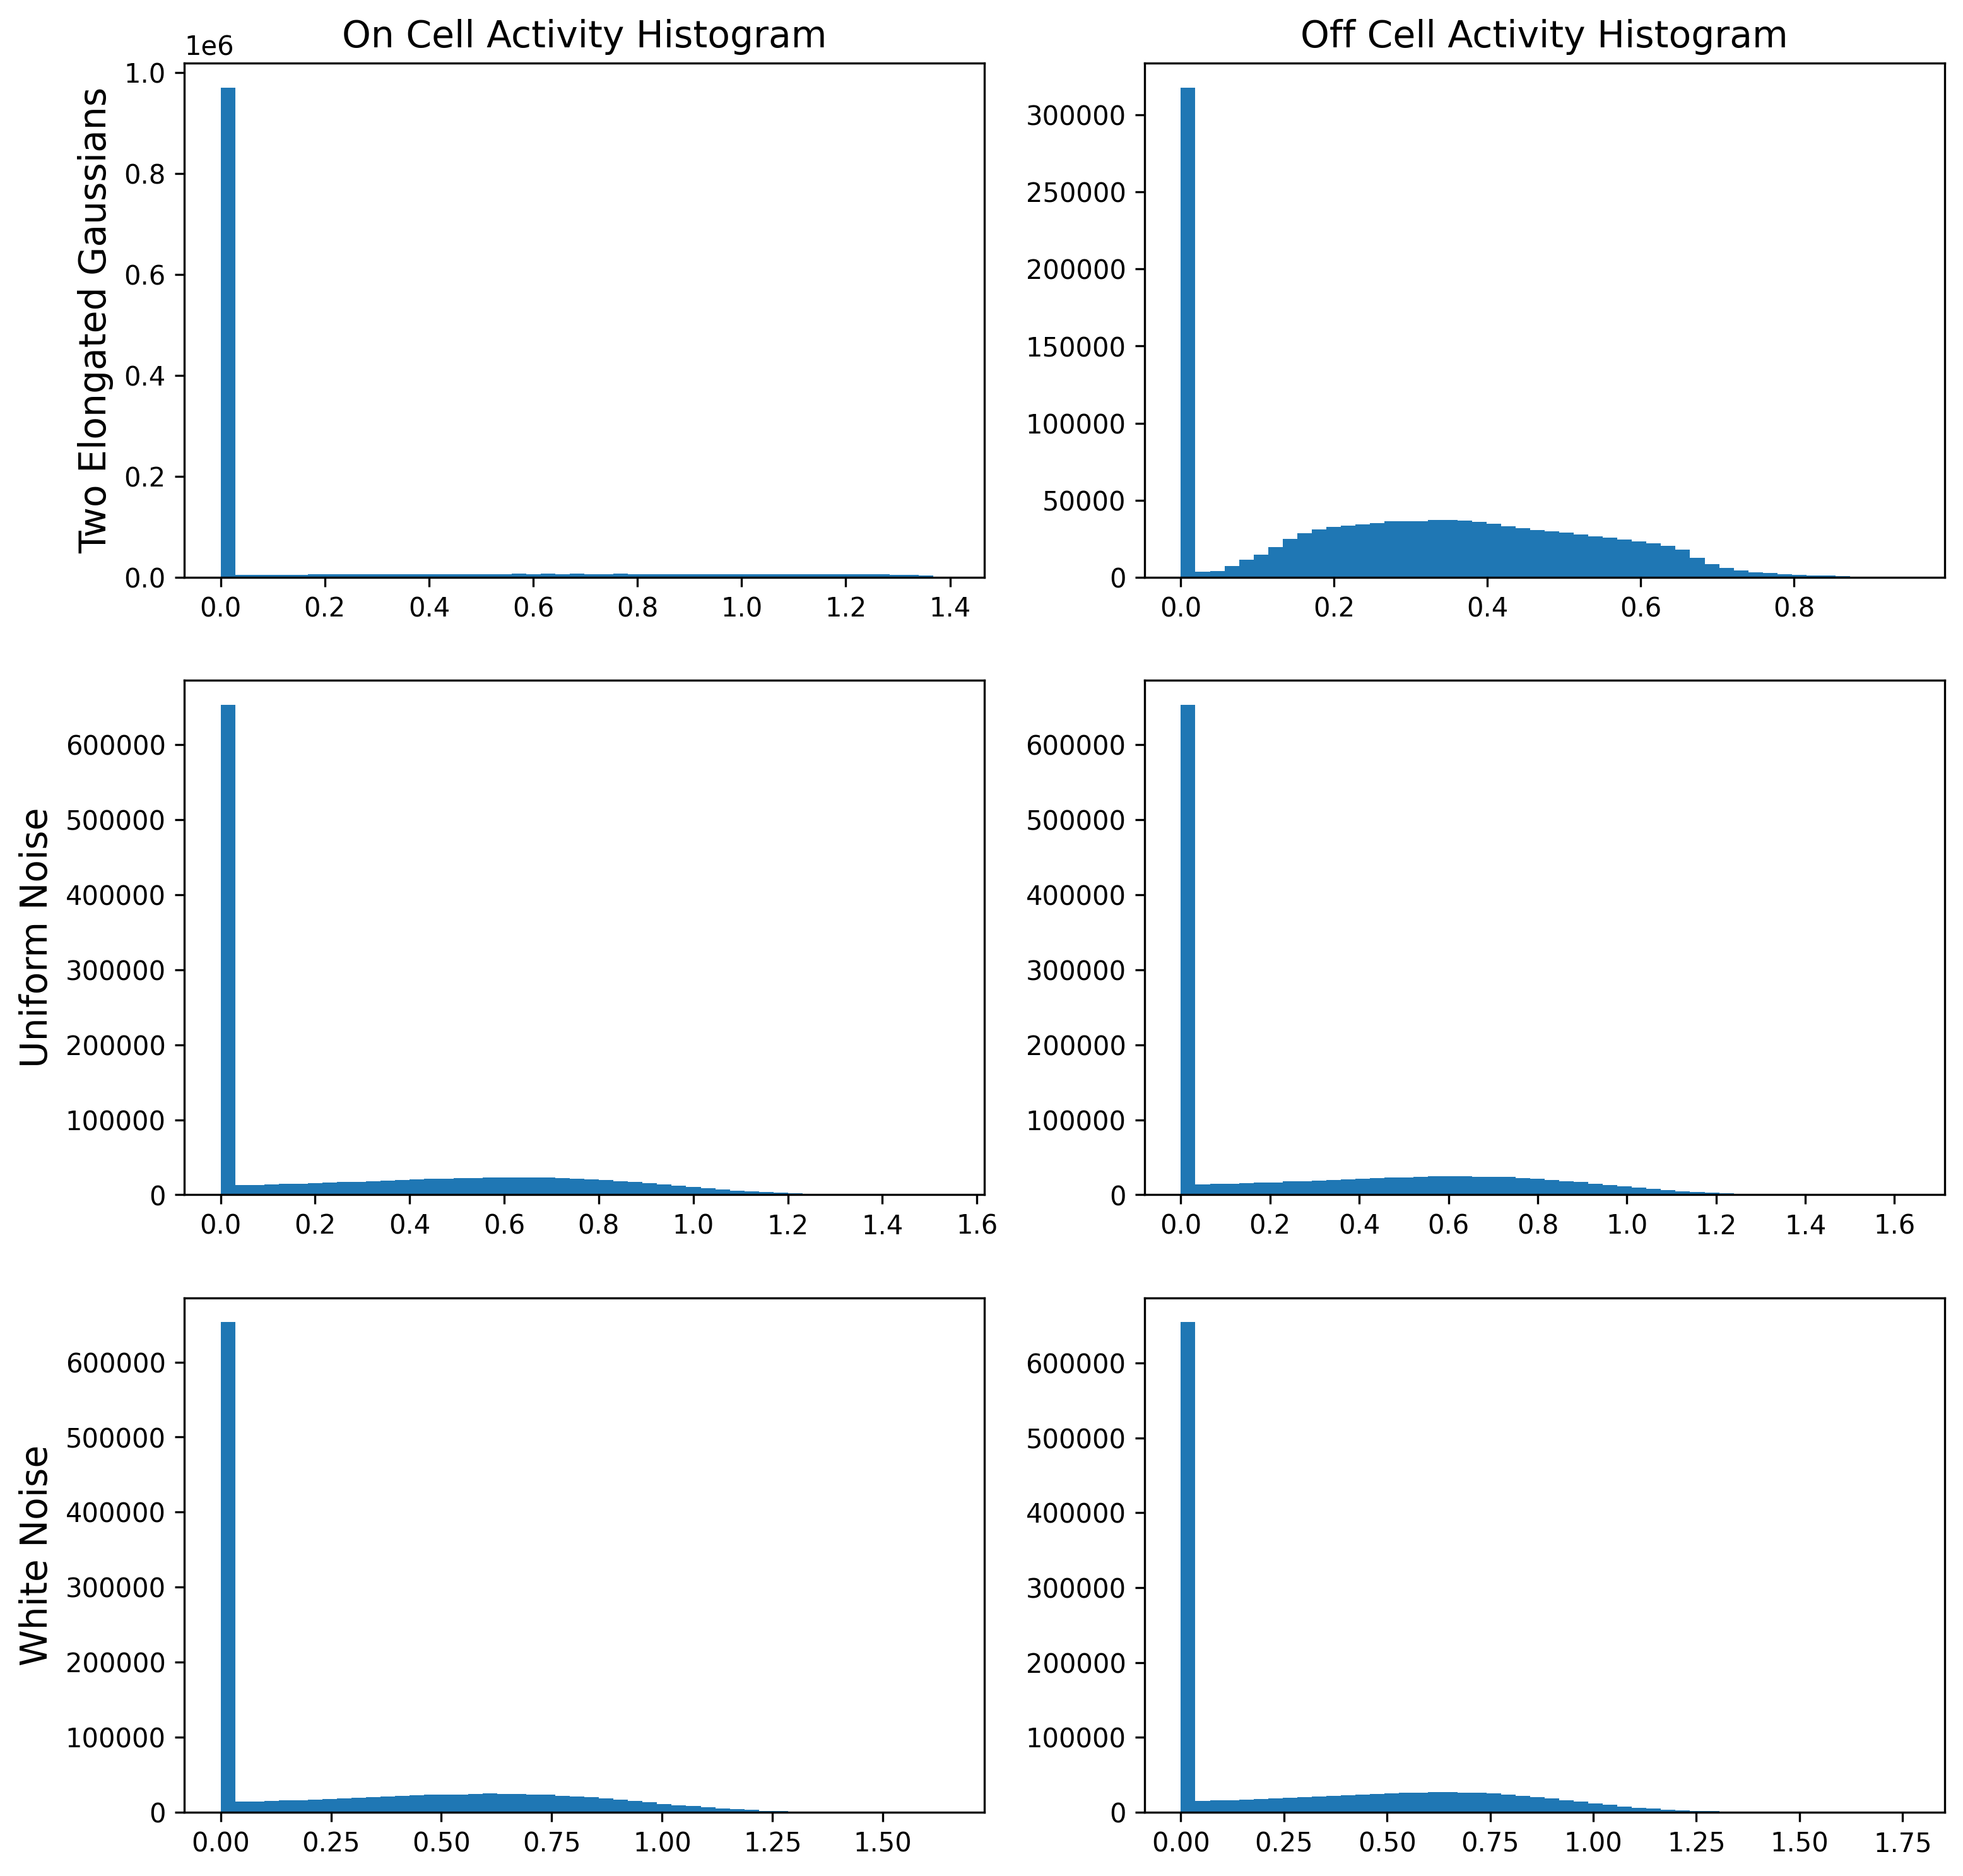

In [66]:
fig,axs = plt.subplots(3,2,figsize=(12,12),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_N_act.flatten(),50)
axs[0,1].hist(gaus_F_act.flatten(),50)
axs[1,0].hist(unif_N_act.flatten(),50)
axs[1,1].hist(unif_F_act.flatten(),50)
axs[2,0].hist(norm_N_act.flatten(),50)
axs[2,1].hist(norm_F_act.flatten(),50)

axs[0,0].set_ylabel('Two Elongated Gaussians',fontsize=14)
axs[1,0].set_ylabel('Uniform Noise',fontsize=14)
axs[2,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('On Cell Activity Histogram',fontsize=14)
axs[0,1].set_title('Off Cell Activity Histogram',fontsize=14)

In [67]:
gaus_full_cov = np.cov(gaus_N_act.T,gaus_F_act.T)
gaus_NN_cov = gaus_full_cov[:N**2,:N**2]
gaus_NF_cov = gaus_full_cov[:N**2,N**2:]
gaus_FN_cov = gaus_full_cov[N**2:,:N**2]
gaus_FF_cov = gaus_full_cov[N**2:,N**2:]

unif_full_cov = np.cov(unif_N_act.T,unif_F_act.T)
unif_NN_cov = unif_full_cov[:N**2,:N**2]
unif_NF_cov = unif_full_cov[:N**2,N**2:]
unif_FN_cov = unif_full_cov[N**2:,:N**2]
unif_FF_cov = unif_full_cov[N**2:,N**2:]

norm_full_cov = np.cov(norm_N_act.T,norm_F_act.T)
norm_NN_cov = norm_full_cov[:N**2,:N**2]
norm_NF_cov = norm_full_cov[:N**2,N**2:]
norm_FN_cov = norm_full_cov[N**2:,:N**2]
norm_FF_cov = norm_full_cov[N**2:,N**2:]

In [68]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

gaus_SN_cov = np.zeros(72)
gaus_SN_cov_err = np.zeros(72)
gaus_SF_cov = np.zeros(72)
gaus_SF_cov_err = np.zeros(72)
gaus_D_cov = np.zeros(72)
gaus_D_cov_err = np.zeros(72)

norm_S_cov = np.zeros(72)
norm_S_cov_err = np.zeros(72)
norm_D_cov = np.zeros(72)
norm_D_cov_err = np.zeros(72)

for idx in range(72):
    gaus_SN_cov[idx] = np.mean(gaus_NN_cov[bin_idxs == idx])
    gaus_SN_cov_err[idx] = np.sqrt(np.var(gaus_NN_cov[bin_idxs == idx]))
    gaus_SF_cov[idx] = np.mean(gaus_FF_cov[bin_idxs == idx])
    gaus_SF_cov_err[idx] = np.sqrt(np.var(gaus_FF_cov[bin_idxs == idx]))
    gaus_D_cov[idx] = 0.5*(np.mean(gaus_NF_cov[bin_idxs == idx]) + np.mean(gaus_NF_cov[bin_idxs == idx]))
    gaus_D_cov_err[idx] = np.sqrt(np.var(gaus_NF_cov[bin_idxs == idx]) + np.var(gaus_NF_cov[bin_idxs == idx]))
    
    norm_S_cov[idx] = 0.5*(np.mean(norm_NN_cov[bin_idxs == idx]) + np.mean(norm_FF_cov[bin_idxs == idx]))
    norm_S_cov_err[idx] = np.sqrt(np.var(norm_NN_cov[bin_idxs == idx]) + np.var(norm_FF_cov[bin_idxs == idx]))
    norm_D_cov[idx] = 0.5*(np.mean(norm_NF_cov[bin_idxs == idx]) + np.mean(norm_NF_cov[bin_idxs == idx]))
    norm_D_cov_err[idx] = np.sqrt(np.var(norm_NF_cov[bin_idxs == idx]) + np.var(norm_NF_cov[bin_idxs == idx]))

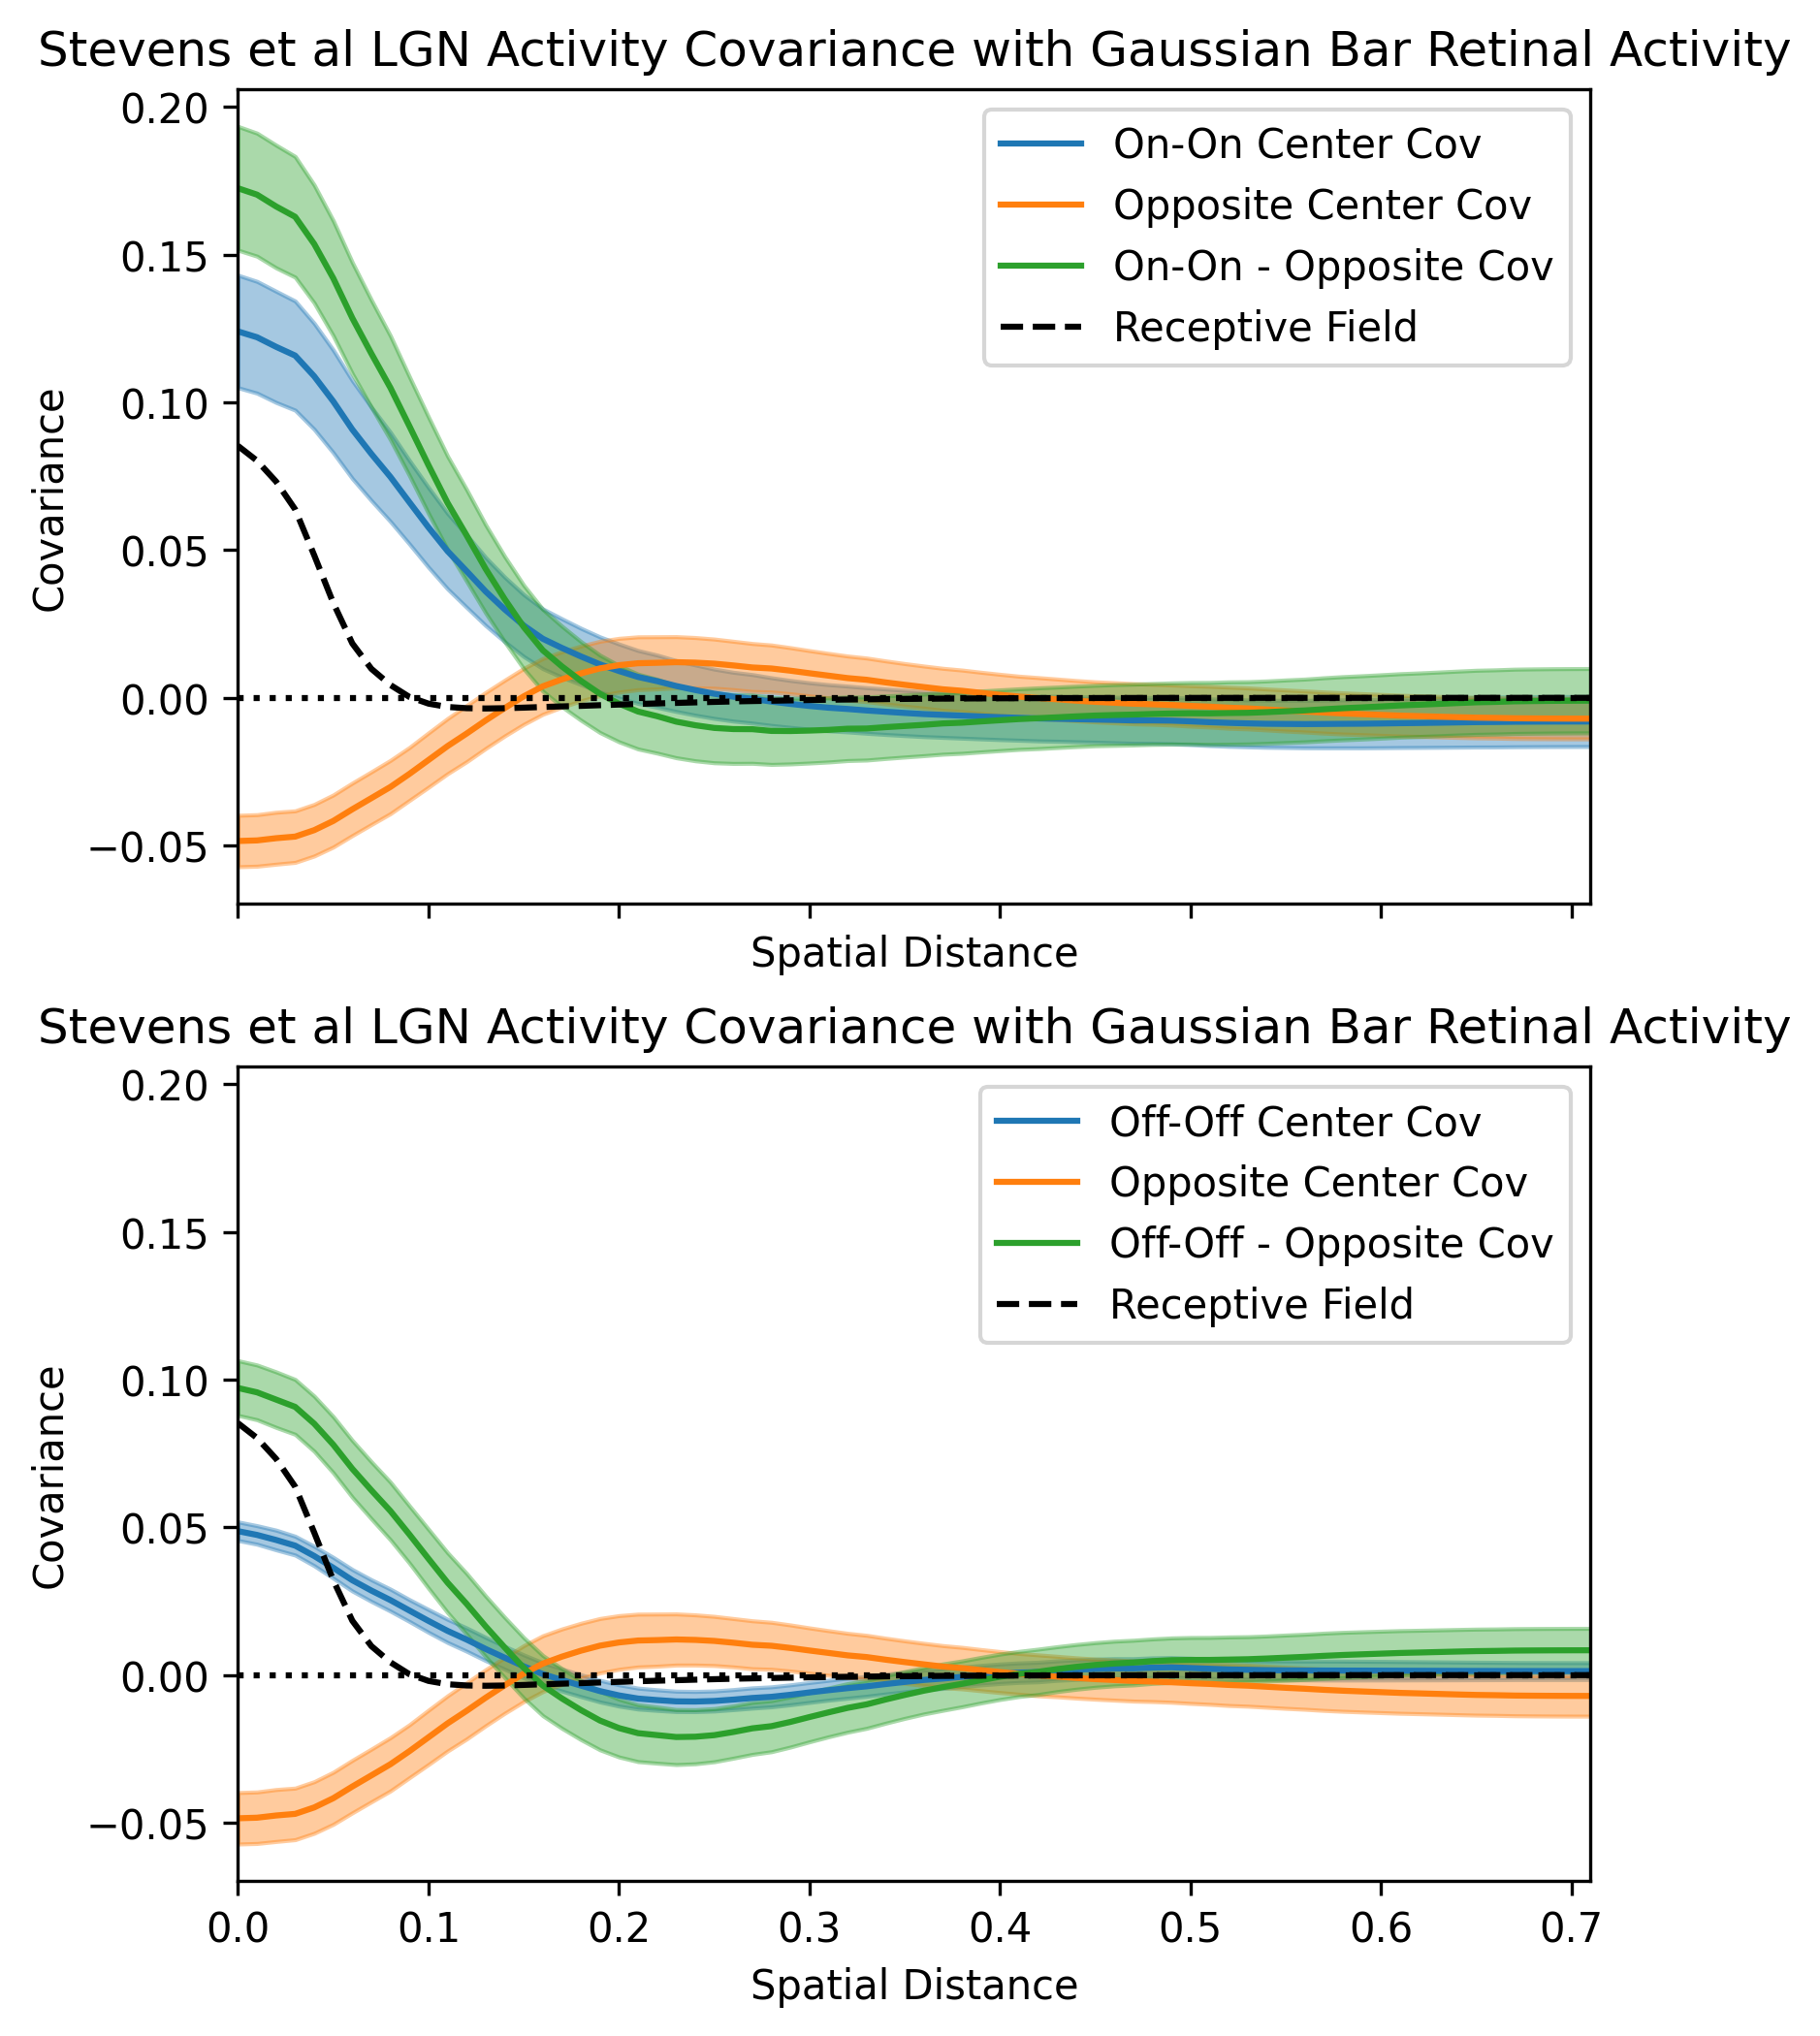

In [71]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,gaus_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C0',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C0',alpha=0.4)
axs[0].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[1].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[0].plot(dists,gaus_SN_cov-gaus_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_D_cov-np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),
                 gaus_SN_cov-gaus_D_cov+np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov-gaus_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_D_cov-np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),
                 gaus_SF_cov-gaus_D_cov+np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)

for i in range(2):    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    axs[i].set_title('Stevens et al LGN Activity Covariance with Gaussian Bar Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

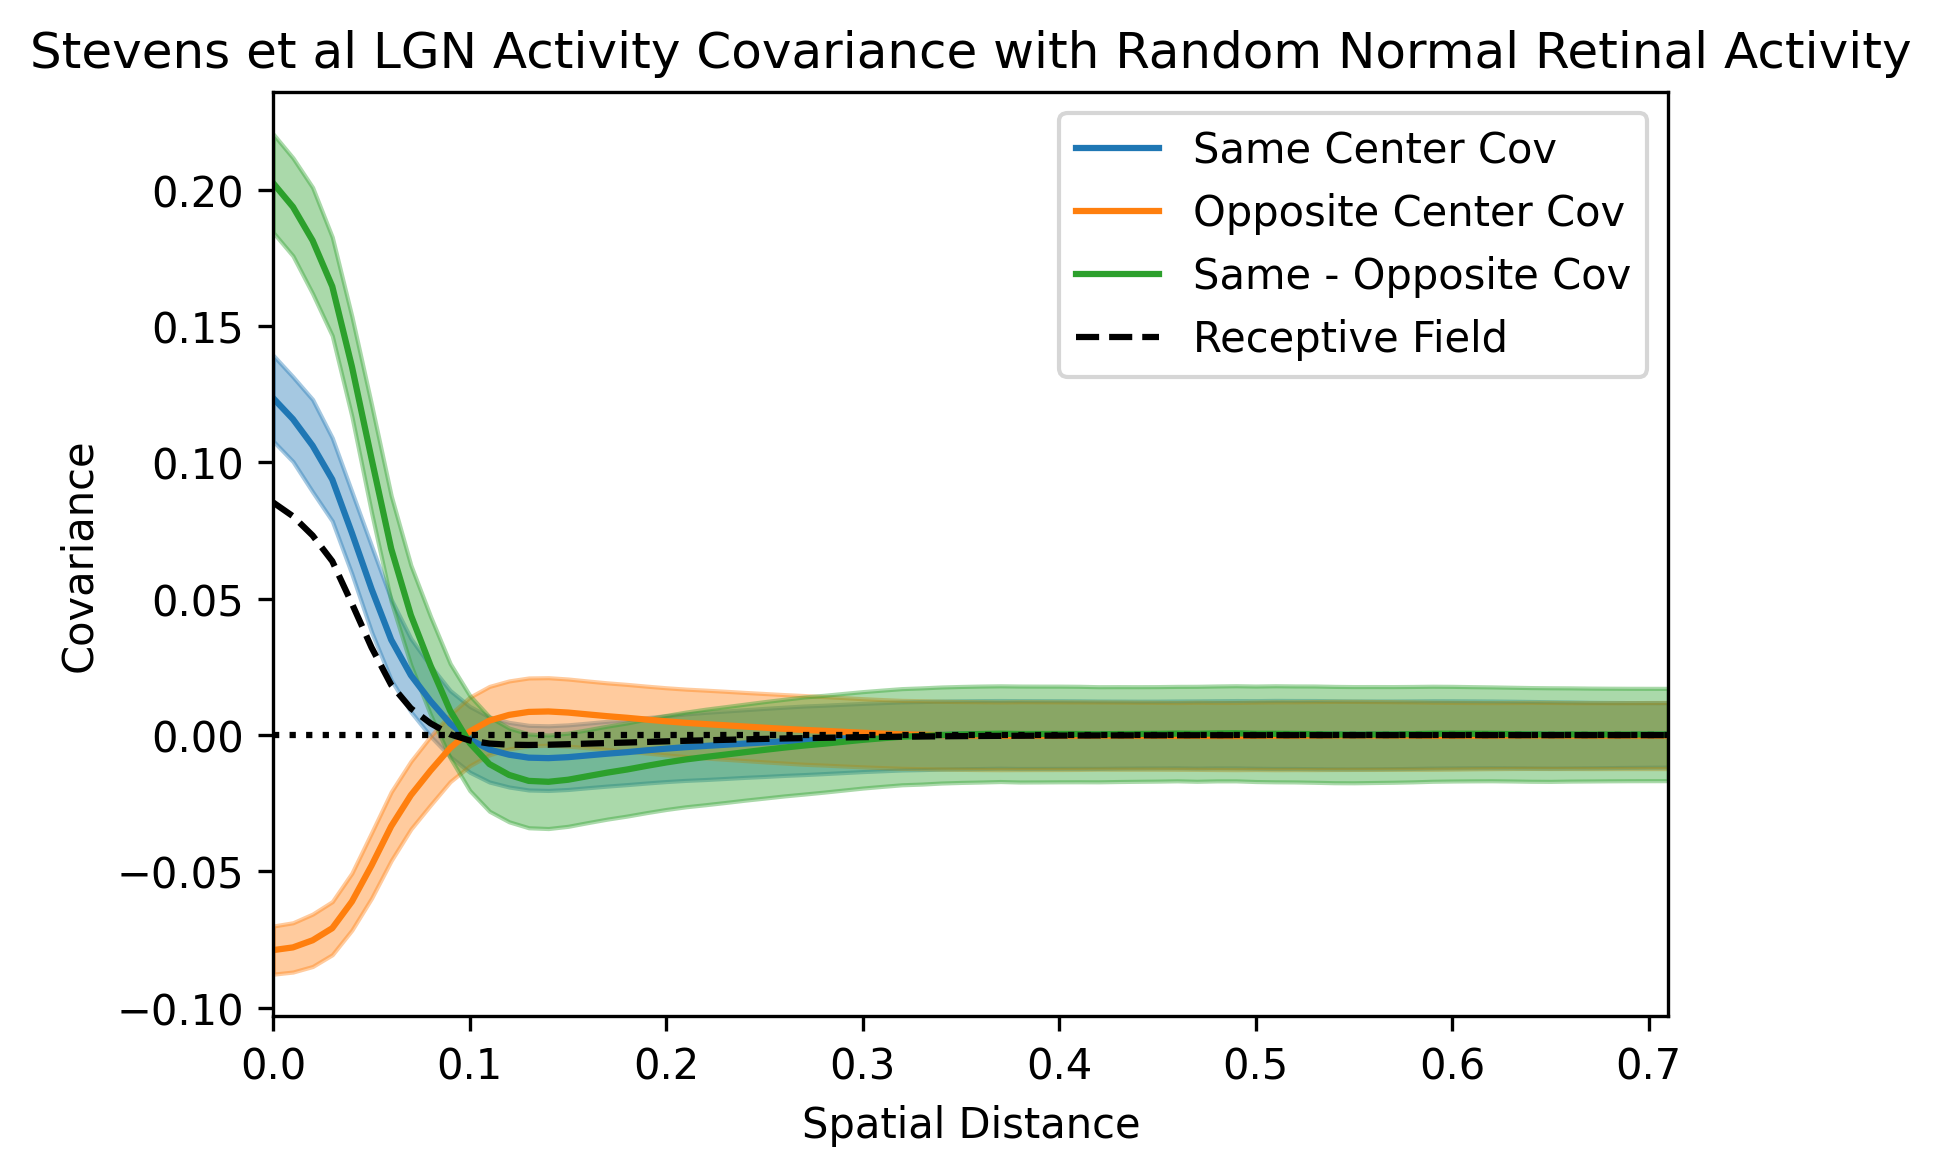

In [70]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,norm_S_cov-norm_S_cov_err,norm_S_cov+norm_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,norm_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,norm_D_cov-norm_D_cov_err,norm_D_cov+norm_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,norm_S_cov-norm_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,norm_S_cov-norm_D_cov-np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),
                 norm_S_cov-norm_D_cov+np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

# Look at Bettina Model's LGN Input with Different On/Off Input

## Create LGN Activity Patterns

In [20]:
inp_params = {
    'onoff_corr_factor': 1.0,
    'input_type': 'white_noise_rect'
}

In [23]:
reload(inputs)

inp = inputs.Inputs_lgn((N,N),0,0)
lgn = inp.create_lgn_input(inp_params,inp_params['input_type'],WRtoT,expansion_timestep=0).numpy()

Text(0.5, 1.0, 'Input to LGN Histogram')

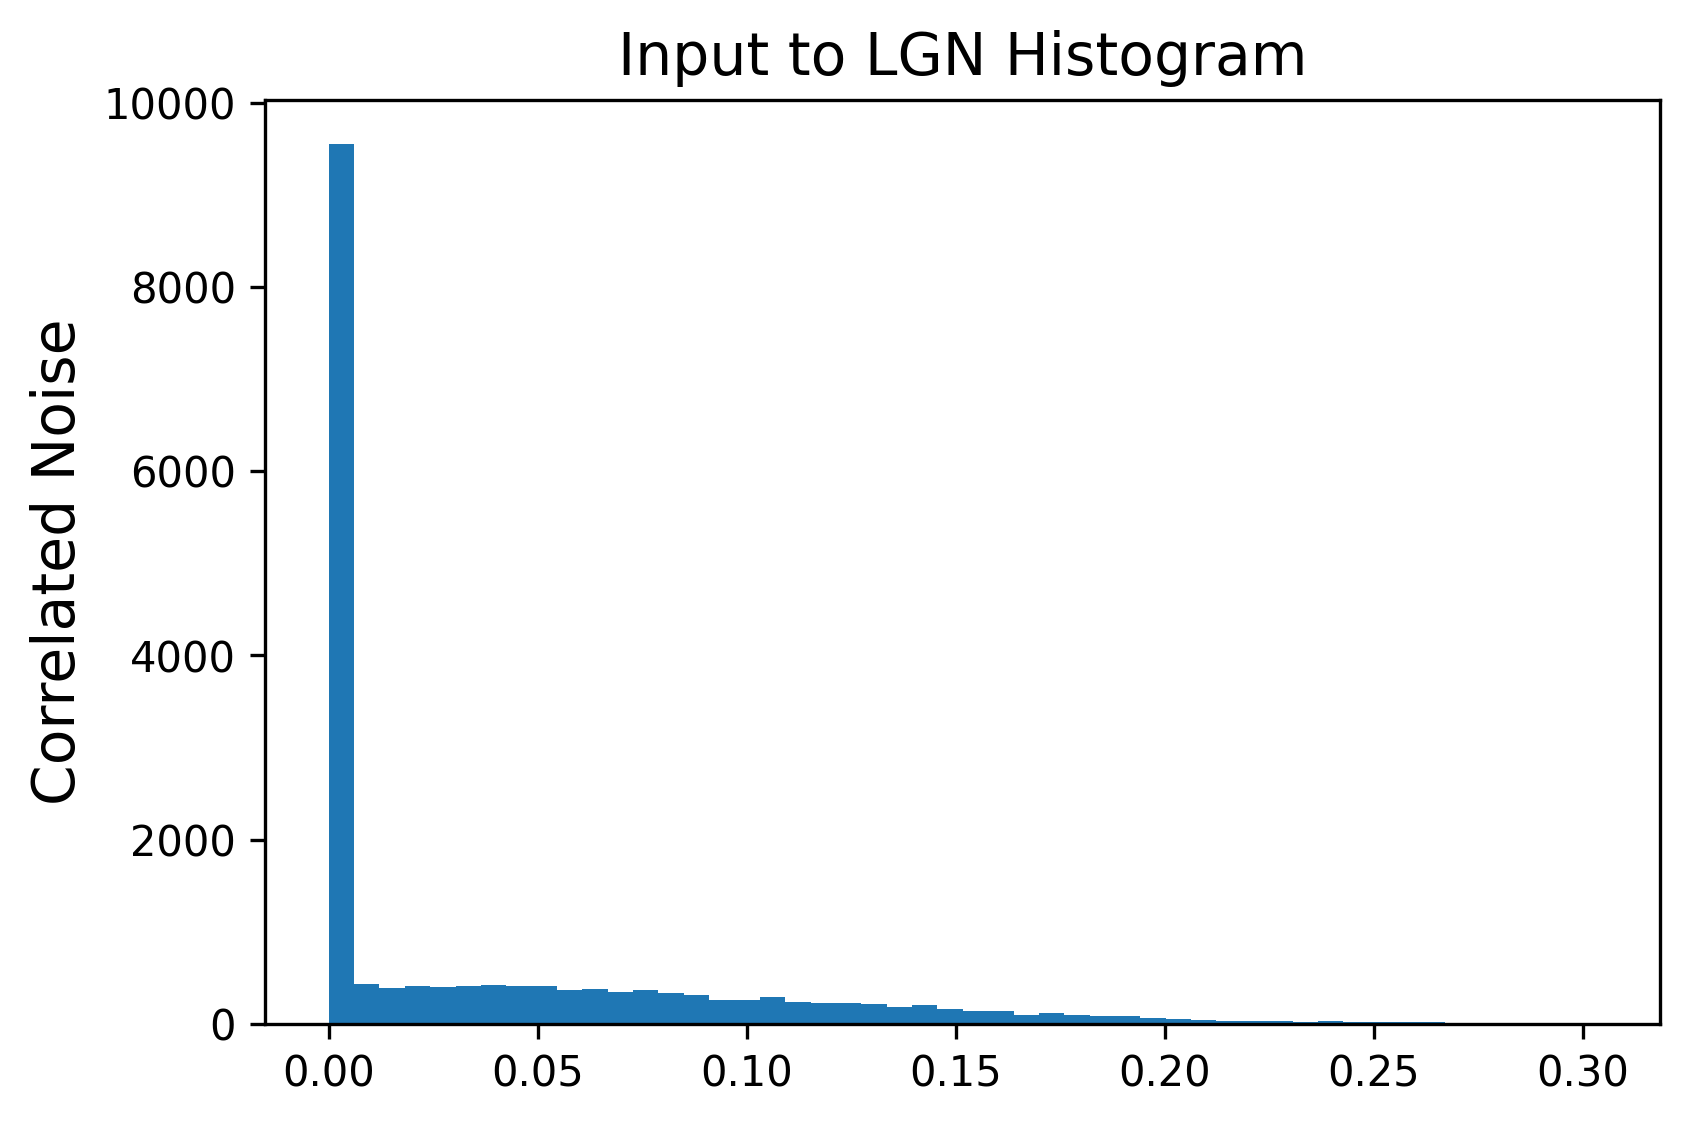

In [24]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.hist(lgn.flatten(),50)

axs.set_ylabel('Correlated Noise',fontsize=14)
axs.set_title('Input to LGN Histogram',fontsize=14)

In [25]:
np.std(lgn)

0.058753185

In [26]:
n_ret_patts = 200

bett_N_act = np.zeros((n_ret_patts,N**2))
bett_F_act = np.zeros((n_ret_patts,N**2))

for i in range(n_ret_patts):
    lgn = inp.create_lgn_input(inp_params,inp_params['input_type'],WRtoT,expansion_timestep=0)
    bett_N_act[i] = 3*lgn[0]
    bett_F_act[i] = 3*lgn[1]

Text(0.5, 1.0, 'Off Cell Activity Histogram')

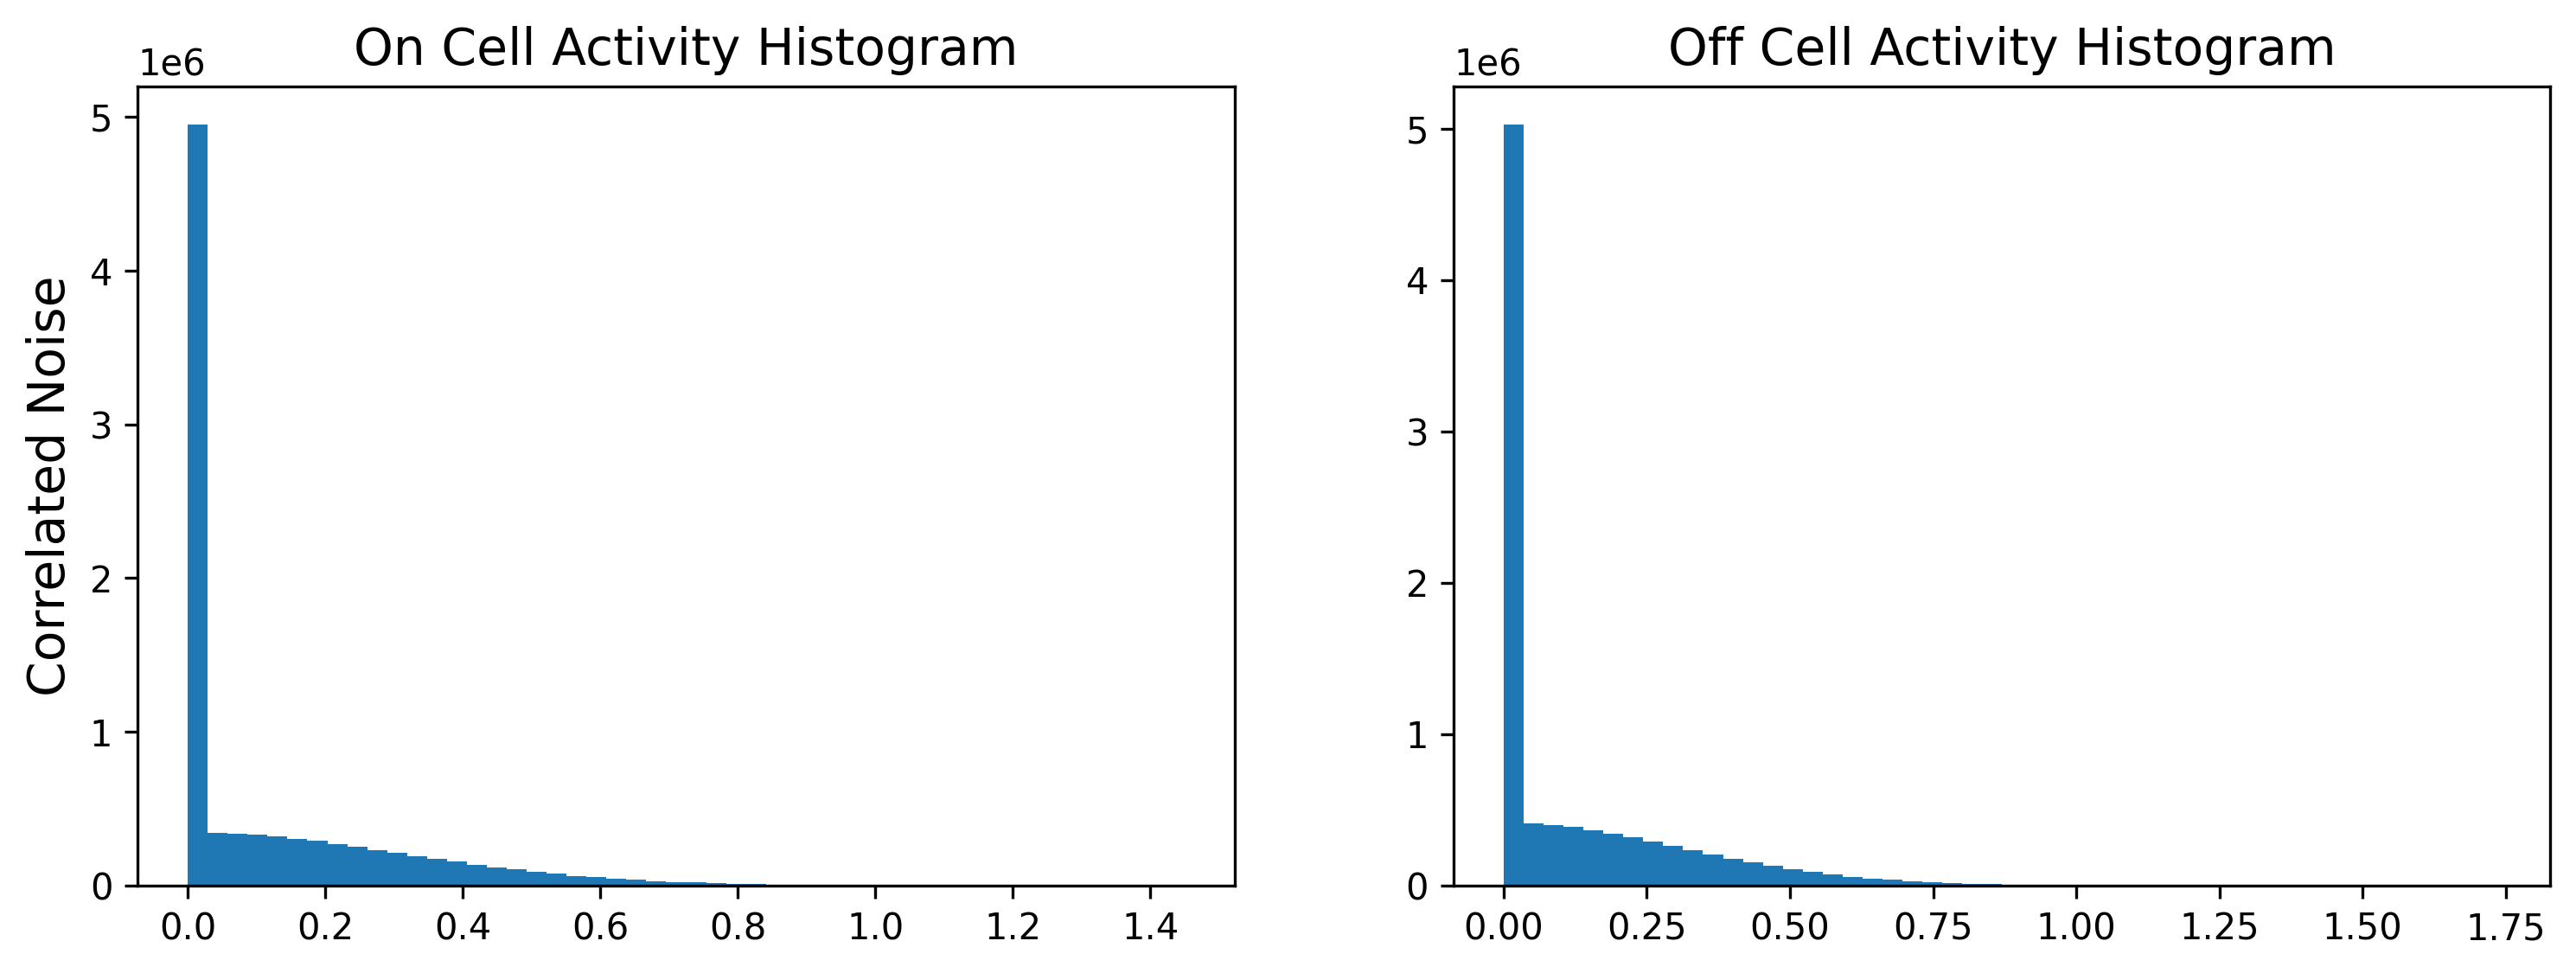

In [27]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].hist(bett_N_act.flatten(),50)
axs[1].hist(bett_F_act.flatten(),50)

axs[0].set_ylabel('Correlated Noise',fontsize=14)
axs[0].set_title('On Cell Activity Histogram',fontsize=14)
axs[1].set_title('Off Cell Activity Histogram',fontsize=14)

## Calculate Spatial Correlations

In [28]:
bett_full_cov = np.cov(bett_N_act.T,bett_F_act.T)
bett_NN_cov = bett_full_cov[:N**2,:N**2]
bett_NF_cov = bett_full_cov[:N**2,N**2:]
bett_FN_cov = bett_full_cov[N**2:,:N**2]
bett_FF_cov = bett_full_cov[N**2:,N**2:]

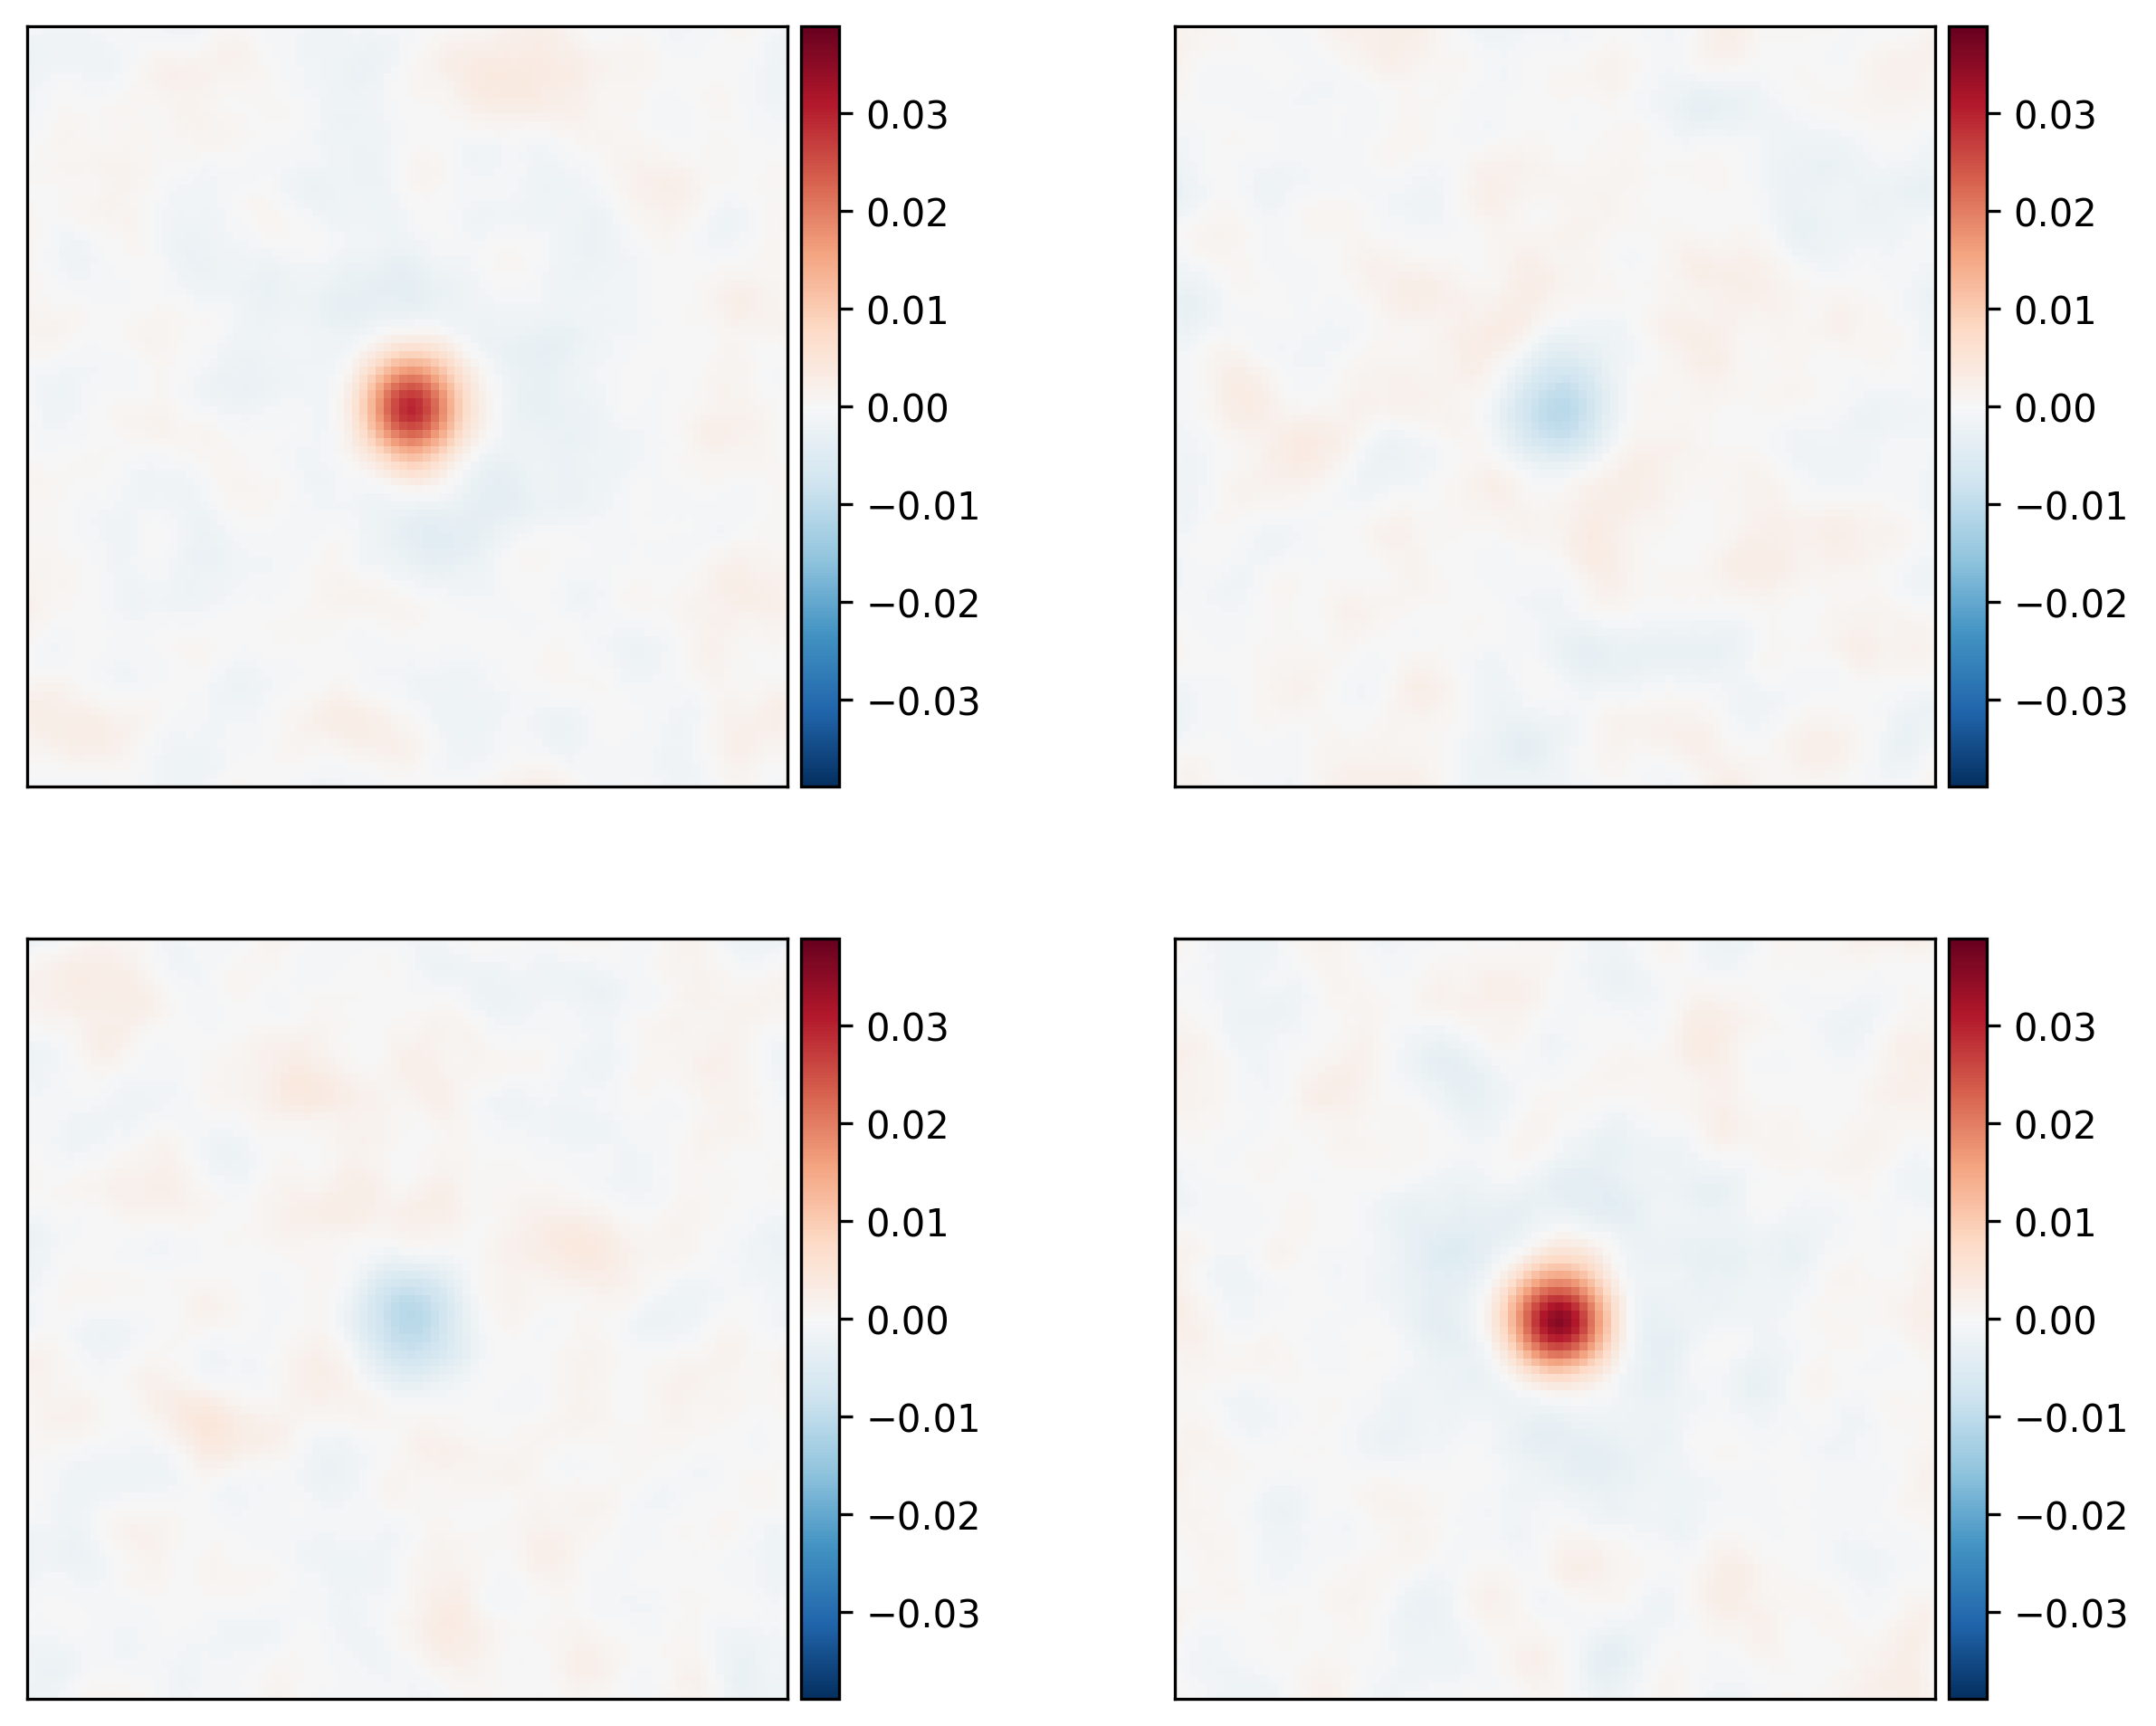

In [29]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = np.max(np.abs(bett_full_cov))

pf.imshowbar(fig,axs[0,0],bett_NN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[0,1],bett_NF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,0],bett_FN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,1],bett_FF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)

In [30]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

bett_S_cov = np.zeros(72)
bett_S_cov_err = np.zeros(72)
bett_D_cov = np.zeros(72)
bett_D_cov_err = np.zeros(72)

for idx in range(72):
    bett_S_cov[idx] = 0.5*(np.mean(bett_NN_cov[bin_idxs == idx]) + np.mean(bett_FF_cov[bin_idxs == idx]))
    bett_S_cov_err[idx] = np.sqrt(np.var(bett_NN_cov[bin_idxs == idx]) + np.var(bett_FF_cov[bin_idxs == idx]))
    bett_D_cov[idx] = 0.5*(np.mean(bett_NF_cov[bin_idxs == idx]) + np.mean(bett_NF_cov[bin_idxs == idx]))
    bett_D_cov_err[idx] = np.sqrt(np.var(bett_NF_cov[bin_idxs == idx]) + np.var(bett_NF_cov[bin_idxs == idx]))

Text(0.5, 1.0, 'Bettina LGN Activity Covariance')

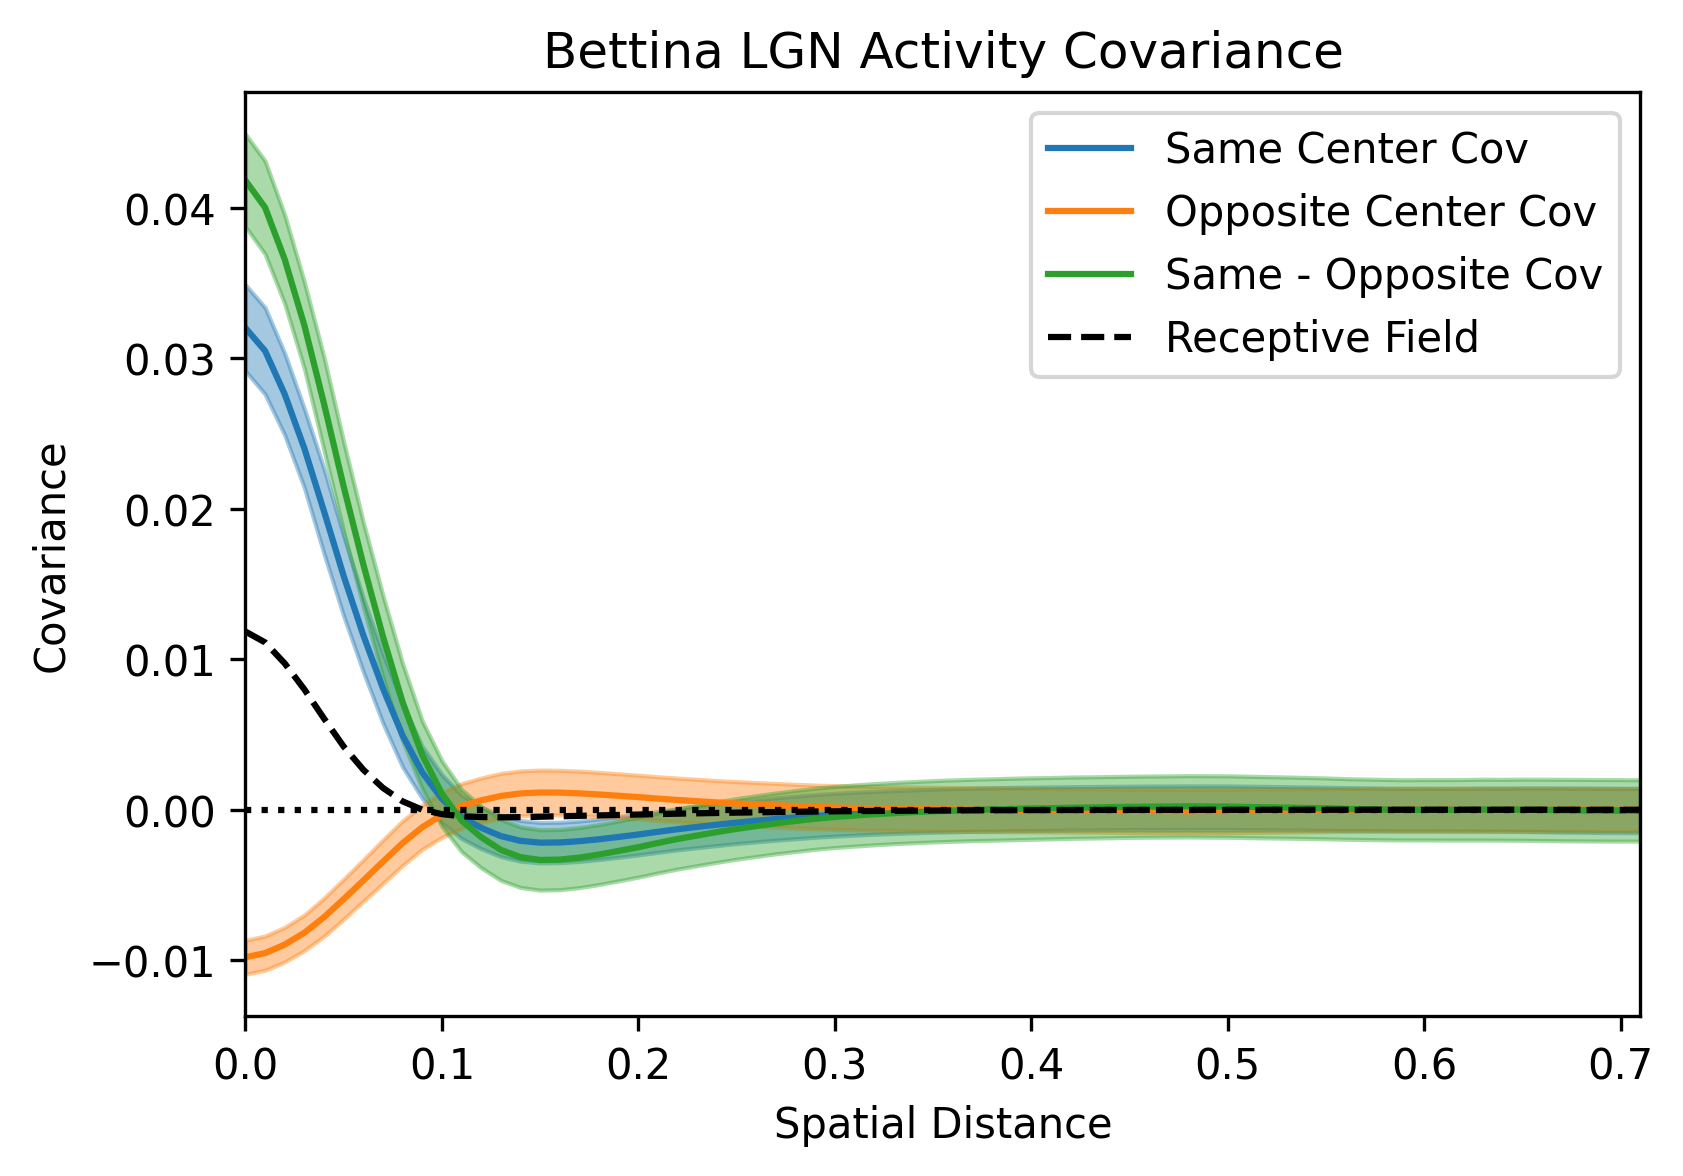

In [31]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,bett_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,bett_S_cov-bett_S_cov_err,bett_S_cov+bett_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,bett_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,bett_D_cov-bett_D_cov_err,bett_D_cov+bett_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,bett_S_cov-bett_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,bett_S_cov-bett_D_cov-np.sqrt(bett_S_cov_err**2+bett_D_cov_err**2),
                 bett_S_cov-bett_D_cov+np.sqrt(bett_S_cov_err**2+bett_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Bettina LGN Activity Covariance')

Text(0.5, 1.0, 'Bettina LGN Activity Covariance')

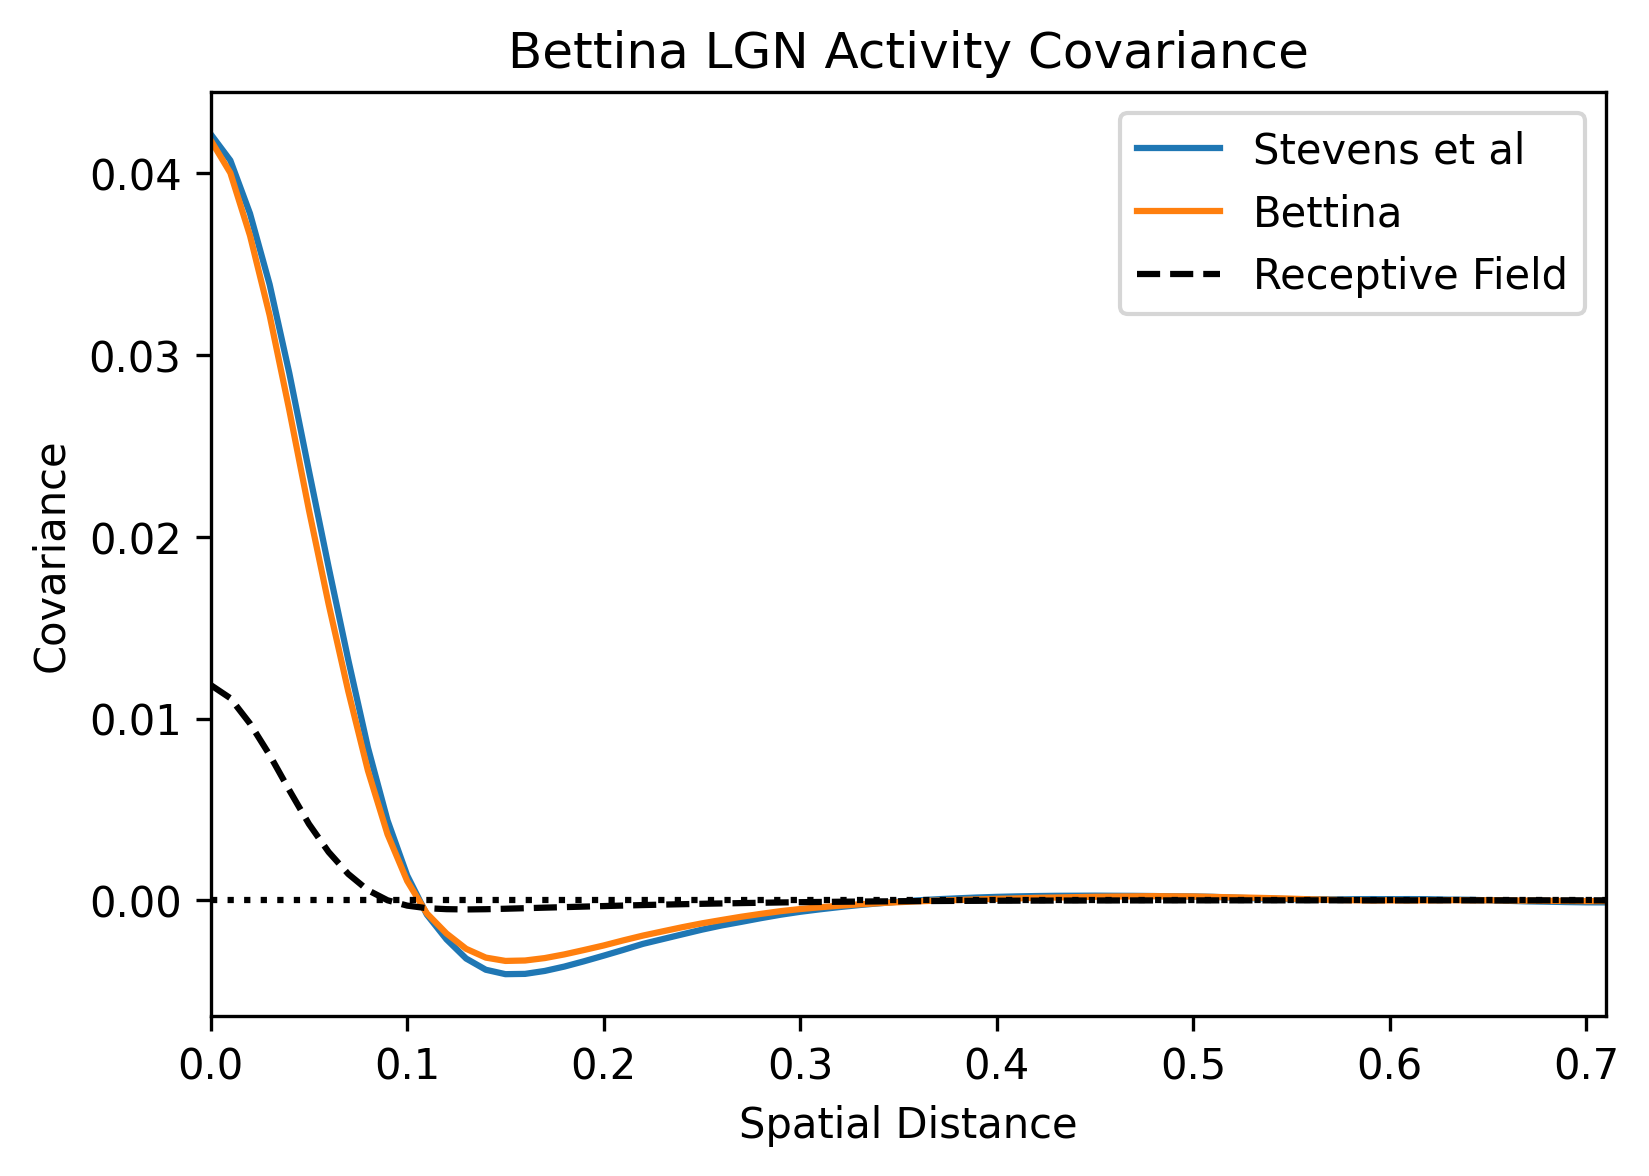

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov - norm_D_cov,c='C0',label='Stevens et al')
axs.plot(dists,bett_S_cov - bett_D_cov,c='C1',label='Bettina')
axs.plot(dists,WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Bettina LGN Activity Covariance')